# Import

## Libraries 

In [2]:
#Intake is a package to load and share datasets, and will be our connection to the cloud via the
#intake-esm catalogue.
import intake

#Xarray is essentially Pandas for n-dimensional datasets (which will be the outputs from
#climate models)
import xarray as xr

#Proplot is the 'next big thing' for data visualisation in Python, apparently.
import proplot

#NetCDF for importing observed datasets
import netCDF4

#These modules are imported for obvious reasons
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(rc={'figure.facecolor':'white'})
plt.style.use('default')

#Parallelisation
from joblib import Parallel, delayed

#remove any warning messages
import warnings
warnings.filterwarnings('ignore')

## GISS Model Experiments

### Data Catalogue

We read the data catalogue provided by https://pangeo.io/cloud.html:

In [2]:
#necessary url
url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"

#open the catalog
dataframe = intake.open_esm_datastore(url)

Check that this dataframe has actually worked:

In [4]:
dataframe

We can see this tells us the number of different model catagories we are able to choose from. <br>We now choose the model from this list, with the <u>following specification</u>:
- source_id = <b>MIROC6</b> (the name of the model)
- experiment_id = <b>historical</b> and <b>AMIP</b> (the ensemble experiments)
- table_id = <b>Amon</b> (monthly atmospheric variables)
- variable_id = <b>tas</b> (temperature at the surface), <b>pr</b> (precipitation flux) and <b>psl</b> (pressure at sea level).

In [3]:
#Historical and AMIP model ensembles
model_ensembles = dataframe.search(source_id='MIROC6',
                                         experiment_id=['historical', 'amip'],
                                         table_id='Amon',
                                         variable_id=['tas','pr','psl'])

This query yields an intake_esm.core.esm_datastore data type, which we can use in order to get the dataset we have searched for.
<br>Before we do this, let's learn a bit more about the model ensembles we're importing:

In [33]:
model_ensembles

### A Look into Ensemble Metadata

In [ ]:
print(model_ensembles.df.head().to_latex(index=False))

In [91]:
model_ensembles.df.loc[model_ensembles.df['experiment_id'] == 'historical'].head()

activity_id institution_id source_id experiment_id member_id table_id  \
0        CMIP          MIROC    MIROC6    historical  r3i1p1f1     Amon   
1        CMIP          MIROC    MIROC6    historical  r8i1p1f1     Amon   
2        CMIP          MIROC    MIROC6    historical  r6i1p1f1     Amon   
3        CMIP          MIROC    MIROC6    historical  r6i1p1f1     Amon   
4        CMIP          MIROC    MIROC6    historical  r6i1p1f1     Amon   

  variable_id grid_label                                             zstore  \
0         psl         gn  gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historical/...   
1         tas         gn  gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historical/...   
2         tas         gn  gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historical/...   
3         psl         gn  gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historical/...   
4          pr         gn  gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historical/...   

   dcpp_init_year   version  
0             NaN  20181212  
1             NaN  20181212  
2             NaN  20181212  
3             NaN  20181212  
4             NaN  20181212

In [4]:
print(
    'The number of simulations in the historical ensemble for temperature at surface (tas) is:',
    model_ensembles.df.loc[
        (model_ensembles.df['experiment_id'] == 'historical')
        & (model_ensembles.df['variable_id'] == 'tas')].shape[0])

The number of simulations in the historical ensemble for temperature at surface (tas) is: 50


In [5]:
print(
    'The number of simulations in the historical ensemble for precipitation flux (pr)) is:',
    model_ensembles.df.loc[
        (model_ensembles.df['experiment_id'] == 'historical')
        & (model_ensembles.df['variable_id'] == 'pr')].shape[0])

The number of simulations in the historical ensemble for precipitation flux (pr)) is: 50


In [6]:
print(
    'The number of simulations in the historical ensemble for air pressure at sea level (psl) is:',
    model_ensembles.df.loc[
        (model_ensembles.df['experiment_id'] == 'historical')
        & (model_ensembles.df['variable_id'] == 'psl')].shape[0])

The number of simulations in the historical ensemble for air pressure at sea level (psl) is: 50


<u>Notice:</u> The number of historical simulations for each variable is the same, which is good news!

In [7]:
model_ensembles.df.loc[model_ensembles.df['experiment_id'] == 'amip'].head()

activity_id institution_id source_id experiment_id member_id table_id  \
30        CMIP          MIROC    MIROC6          amip  r2i1p1f1     Amon   
31        CMIP          MIROC    MIROC6          amip  r2i1p1f1     Amon   
32        CMIP          MIROC    MIROC6          amip  r2i1p1f1     Amon   
33        CMIP          MIROC    MIROC6          amip  r9i1p1f1     Amon   
34        CMIP          MIROC    MIROC6          amip  r9i1p1f1     Amon   

   variable_id grid_label                                             zstore  \
30         psl         gn  gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/amip/r2i1p1...   
31         tas         gn  gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/amip/r2i1p1...   
32          pr         gn  gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/amip/r2i1p1...   
33         tas         gn  gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/amip/r9i1p1...   
34          pr         gn  gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/amip/r9i1p1...   

    dcpp_init_year   version  
30             NaN  20181214  
31             NaN  20181214  
32             NaN  20181214  
33             NaN  20181214  
34             NaN  20181214

In [8]:
print(
    'The number of simulations in the AMIP ensemble for temperature at surface (tas) is:',
    model_ensembles.df.loc[
        (model_ensembles.df['experiment_id'] == 'amip')
        & (model_ensembles.df['variable_id'] == 'tas')].shape[0])

The number of simulations in the AMIP ensemble for temperature at surface (tas) is: 10


In [9]:
print(
    'The number of simulations in the AMIP ensemble for precipitation flux (pr) is:',
    model_ensembles.df.loc[
        (model_ensembles.df['experiment_id'] == 'amip')
        & (model_ensembles.df['variable_id'] == 'pr')].shape[0])

The number of simulations in the AMIP ensemble for precipitation flux (pr) is: 10


In [10]:
print(
    'The number of simulations in the AMIP ensemble for air pressure at sea level (psl) is:',
    model_ensembles.df.loc[
        (model_ensembles.df['experiment_id'] == 'amip')
        & (model_ensembles.df['variable_id'] == 'psl')].shape[0])

The number of simulations in the AMIP ensemble for air pressure at sea level (psl) is: 10


<u>Notice:</u> The number of AMIP simulations for each variable is the same, which is good news!

### Downloading the Data

In [5]:
model_ensembles_dataset = model_ensembles.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


We check what we have downloaded:

In [56]:
model_ensembles_dataset.keys()

dict_keys(['CMIP.MIROC.MIROC6.amip.Amon.gn', 'CMIP.MIROC.MIROC6.historical.Amon.gn'])

In [6]:
#AMIP datasets
model_amip_ds = model_ensembles_dataset['CMIP.MIROC.MIROC6.amip.Amon.gn']

#Historical datasets
model_historical_ds = model_ensembles_dataset['CMIP.MIROC.MIROC6.historical.Amon.gn']

# Analysing the Model

## Checking the Data Structure

The above are xarray.core.dataset.Dataset straight away, meaning they can be readily used for anything one would want with the Xarray package (which is suited to work with gridded meteorological data).

In [58]:
model_amip_ds

<xarray.Dataset>
Dimensions:    (member_id: 10, lat: 128, bnds: 2, lon: 256, time: 432)
Coordinates:
  * member_id  (member_id) <U9 'r10i1p1f1' 'r1i1p1f1' ... 'r8i1p1f1' 'r9i1p1f1'
  * lat        (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(128, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(256, 2), meta=np.ndarray>
  * time       (time) datetime64[ns] 1979-01-16T12:00:00 ... 2014-12-16T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(432, 2), meta=np.ndarray>
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    pr         (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 432, 128, 256), meta=np.ndarray>
    psl        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 432, 128, 256), meta=np.ndarray>
    tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 432, 128, 256), meta=np.ndarray>
Attributes: (12/38)
    external_variables:      areacella
    institution_id:          MIROC
    nominal_resolution:      250 km
    sub_experiment_id:       none
    initialization_index:    1
    data_specs_version:      01.00.28
    ...                      ...
    experiment:              AMIP
    activity_id:             CMIP
    table_id:                Amon
    cmor_version:            3.3.2
    history:                 2018-12-13T06:42:24Z ; CMOR rewrote data to be c...
    intake_esm_dataset_key:  CMIP.MIROC.MIROC6.amip.Amon.gn

We verify that this has lat x lon = 128 x 256, 10 members in the ensemble, and spans 1979-2014.
<br> Moreover, the variables tas, pr and psl are float32 values within an array (ensemble, time, lat, lon).

In [59]:
model_historical_ds

<xarray.Dataset>
Dimensions:    (member_id: 50, lat: 128, bnds: 2, lon: 256, time: 1980)
Coordinates:
  * member_id  (member_id) <U9 'r10i1p1f1' 'r11i1p1f1' ... 'r8i1p1f1' 'r9i1p1f1'
  * lat        (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(128, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(256, 2), meta=np.ndarray>
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(1980, 2), meta=np.ndarray>
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    pr         (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 488, 128, 256), meta=np.ndarray>
    psl        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 600, 128, 256), meta=np.ndarray>
    tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 600, 128, 256), meta=np.ndarray>
Attributes: (12/43)
    external_variables:      areacella
    sub_experiment_id:       none
    product:                 model-output
    source_type:             AOGCM AER
    variable_id:             tas
    license:                 CMIP6 model data produced by MIROC is licensed u...
    ...                      ...
    version_id:              v20200519
    parent_activity_id:      CMIP
    sub_experiment:          none
    activity_id:             CMIP
    cmor_version:            3.5.0
    intake_esm_dataset_key:  CMIP.MIROC.MIROC6.historical.Amon.gn

We verify that this has lat x lon = 128 x 256, 50 members in the ensemble, and spans 1850-2014.
<br> Moreover, the variables tas, pr and psl are float32 values within an array (ensemble, time, lat, lon).

In [60]:
model_historical_ds.tas

<xarray.DataArray 'tas' (member_id: 50, time: 1980, lat: 128, lon: 256)>
dask.array<getitem, shape=(50, 1980, 128, 256), dtype=float32, chunksize=(1, 600, 128, 256), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U9 'r10i1p1f1' 'r11i1p1f1' ... 'r8i1p1f1' 'r9i1p1f1'
  * lat        (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon        (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
    height     float64 ...
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    long_name:      Near-Surface Air Temperature
    original_name:  T2
    standard_name:  air_temperature
    units:          K

## Match Time Periods

We must match the time periods of each experiment ensemble, which equates to:
- Change the start time of the historical ensemble to 1979-01-16

<br><u>Note</u>: The end time of the AMIP ensemble is already 2014-12-16, so no changes needed here.

In [7]:
model_historical_ds = model_historical_ds.sel(time=model_historical_ds.time.dt.year.isin(range(1979,2015)))

We can see this successfully truncates the starting year to 1979.

In [62]:
model_historical_ds.time.dt.year

<xarray.DataArray 'year' (time: 432)>
array([1979, 1979, 1979, 1979, 1979, 1979, 1979, 1979, 1979, 1979, 1979,
       1979, 1980, 1980, 1980, 1980, 1980, 1980, 1980, 1980, 1980, 1980,
       1980, 1980, 1981, 1981, 1981, 1981, 1981, 1981, 1981, 1981, 1981,
       1981, 1981, 1981, 1982, 1982, 1982, 1982, 1982, 1982, 1982, 1982,
       1982, 1982, 1982, 1982, 1983, 1983, 1983, 1983, 1983, 1983, 1983,
       1983, 1983, 1983, 1983, 1983, 1984, 1984, 1984, 1984, 1984, 1984,
       1984, 1984, 1984, 1984, 1984, 1984, 1985, 1985, 1985, 1985, 1985,
       1985, 1985, 1985, 1985, 1985, 1985, 1985, 1986, 1986, 1986, 1986,
       1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1987, 1987, 1987,
       1987, 1987, 1987, 1987, 1987, 1987, 1987, 1987, 1987, 1988, 1988,
       1988, 1988, 1988, 1988, 1988, 1988, 1988, 1988, 1988, 1988, 1989,
       1989, 1989, 1989, 1989, 1989, 1989, 1989, 1989, 1989, 1989, 1989,
       1990, 1990, 1990, 1990, 1990, 1990, 1990, 1990, 1990, 1990, 1990,
       1990, 1991, 1991, 1991, 1991, 1991, 1991, 1991, 1991, 1991, 1991,
       1991, 1991, 1992, 1992, 1992, 1992, 1992, 1992, 1992, 1992, 1992,
       1992, 1992, 1992, 1993, 1993, 1993, 1993, 1993, 1993, 1993, 1993,
       1993, 1993, 1993, 1993, 1994, 1994, 1994, 1994, 1994, 1994, 1994,
       1994, 1994, 1994, 1994, 1994, 1995, 1995, 1995, 1995, 1995, 1995,
       1995, 1995, 1995, 1995, 1995, 1995, 1996, 1996, 1996, 1996, 1996,
       1996, 1996, 1996, 1996, 1996, 1996, 1996, 1997, 1997, 1997, 1997,
       1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1998, 1998, 1998,
       1998, 1998, 1998, 1998, 1998, 1998, 1998, 1998, 1998, 1999, 1999,
       1999, 1999, 1999, 1999, 1999, 1999, 1999, 1999, 1999, 1999, 2000,
       2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000,
       2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001,
       2001, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002,
       2002, 2002, 2003, 2003, 2003, 2003, 2003, 2003, 2003, 2003, 2003,
       2003, 2003, 2003, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004,
       2004, 2004, 2004, 2004, 2005, 2005, 2005, 2005, 2005, 2005, 2005,
       2005, 2005, 2005, 2005, 2005, 2006, 2006, 2006, 2006, 2006, 2006,
       2006, 2006, 2006, 2006, 2006, 2006, 2007, 2007, 2007, 2007, 2007,
       2007, 2007, 2007, 2007, 2007, 2007, 2007, 2008, 2008, 2008, 2008,
       2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2009, 2009, 2009,
       2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2010, 2010,
       2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2011,
       2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011,
       2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012,
       2012, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013,
       2013, 2013, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014,
       2014, 2014, 2014], dtype=int64)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-16T12:00:00 ... 2014-12-16T12:00:00
    height   float64 ...

## Restrict to Australia

Due to different griddings of each model, we have to 'guess' where Australia should be and verify on a projection plot:

In [8]:
#Set lat and lon indices for each experiment
A_lat = range(32, 58)
A_lon = range(80,113)

#Tas variable
model_historical_A_tas_ds = model_historical_ds['tas'][:, :, A_lat, A_lon]
model_amip_A_tas_ds = model_amip_ds['tas'][:, :, A_lat, A_lon]

#Pr variable
model_historical_A_pr_ds = model_historical_ds['pr'][:, :, A_lat, A_lon]
model_amip_A_pr_ds = model_amip_ds['pr'][:, :, A_lat, A_lon]

#Psl variable
model_historical_A_psl_ds = model_historical_ds['psl'][:, :, A_lat, A_lon]
model_amip_A_psl_ds = model_amip_ds['psl'][:, :, A_lat, A_lon]

### Brief Analysis

In [69]:
model_historical_A_tas_ds

<xarray.DataArray 'tas' (member_id: 50, time: 432, lat: 30, lon: 4)>
dask.array<getitem, shape=(50, 432, 30, 4), dtype=float32, chunksize=(1, 252, 30, 4), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U9 'r10i1p1f1' 'r11i1p1f1' ... 'r8i1p1f1' 'r9i1p1f1'
  * lat        (lat) float64 -60.93 -59.53 -58.13 ... -23.11 -21.71 -20.31
  * lon        (lon) float64 195.5 198.3 199.7 201.1
  * time       (time) datetime64[ns] 1979-01-16T12:00:00 ... 2014-12-16T12:00:00
    height     float64 ...
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    long_name:      Near-Surface Air Temperature
    original_name:  T2
    standard_name:  air_temperature
    units:          K

In [70]:
model_historical_A_pr_ds

<xarray.DataArray 'pr' (member_id: 50, time: 432, lat: 30, lon: 4)>
dask.array<getitem, shape=(50, 432, 30, 4), dtype=float32, chunksize=(1, 252, 30, 4), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U9 'r10i1p1f1' 'r11i1p1f1' ... 'r8i1p1f1' 'r9i1p1f1'
  * lat        (lat) float64 -60.93 -59.53 -58.13 ... -23.11 -21.71 -20.31
  * lon        (lon) float64 195.5 198.3 199.7 201.1
  * time       (time) datetime64[ns] 1979-01-16T12:00:00 ... 2014-12-16T12:00:00
    height     float64 ...
Attributes:
    cell_measures:   area: areacella
    cell_methods:    area: time: mean
    comment:         includes both liquid and solid phases
    long_name:       Precipitation
    original_name:   PRCP
    original_units:  kg/m**2/s
    standard_name:   precipitation_flux
    units:           kg m-2 s-1

In [71]:
model_historical_A_psl_ds

<xarray.DataArray 'psl' (member_id: 50, time: 432, lat: 30, lon: 4)>
dask.array<getitem, shape=(50, 432, 30, 4), dtype=float32, chunksize=(1, 252, 30, 4), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U9 'r10i1p1f1' 'r11i1p1f1' ... 'r8i1p1f1' 'r9i1p1f1'
  * lat        (lat) float64 -60.93 -59.53 -58.13 ... -23.11 -21.71 -20.31
  * lon        (lon) float64 195.5 198.3 199.7 201.1
  * time       (time) datetime64[ns] 1979-01-16T12:00:00 ... 2014-12-16T12:00:00
    height     float64 ...
Attributes:
    cell_measures:   area: areacella
    cell_methods:    area: time: mean
    comment:         Sea Level Pressure
    long_name:       Sea Level Pressure
    original_name:   SLPEC
    original_units:  hPa
    standard_name:   air_pressure_at_mean_sea_level
    units:           Pa

We can see that these datasets are restricted to the geographical location of Ireland.

## Visualising the Data

We create a plot of the first few members of the historical ensemble in the first month:

### Global

We plot some ensembles:

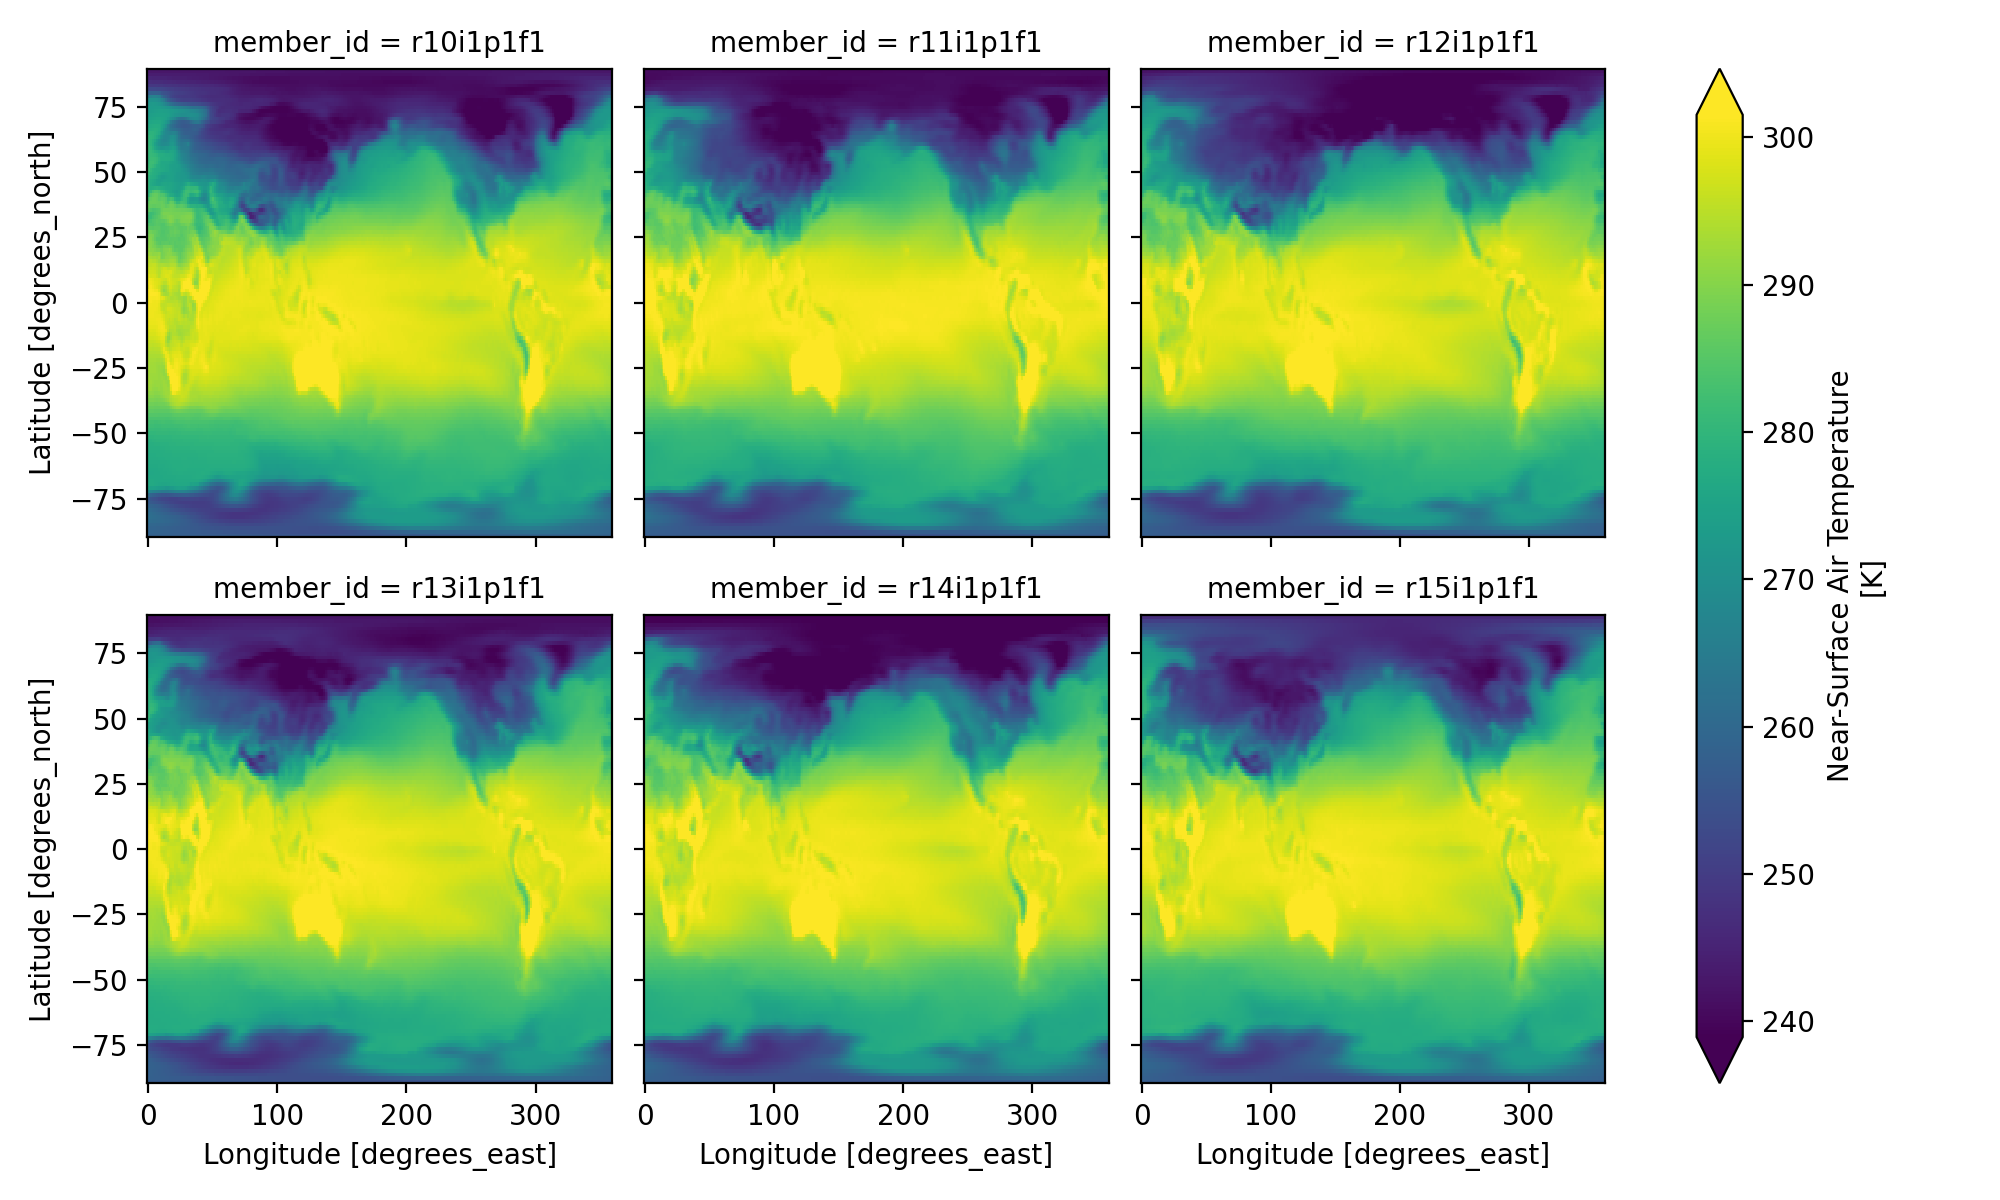

In [86]:
#Global historical Near-Surface Temperature Ensembles in 1979-01
model_historical_ds.tas.isel(time=0, member_id=range(0, 6)).plot(col='member_id',
                                                          col_wrap=3,
                                                          robust=True)

plt.suptitle("MIROC Global Distribution of Tas in 1979-01 in Historical Ensemble", y=1.1)

plt.savefig('images/Global_historical_tas_ensemble', bbox_inches='tight', dpi=300)

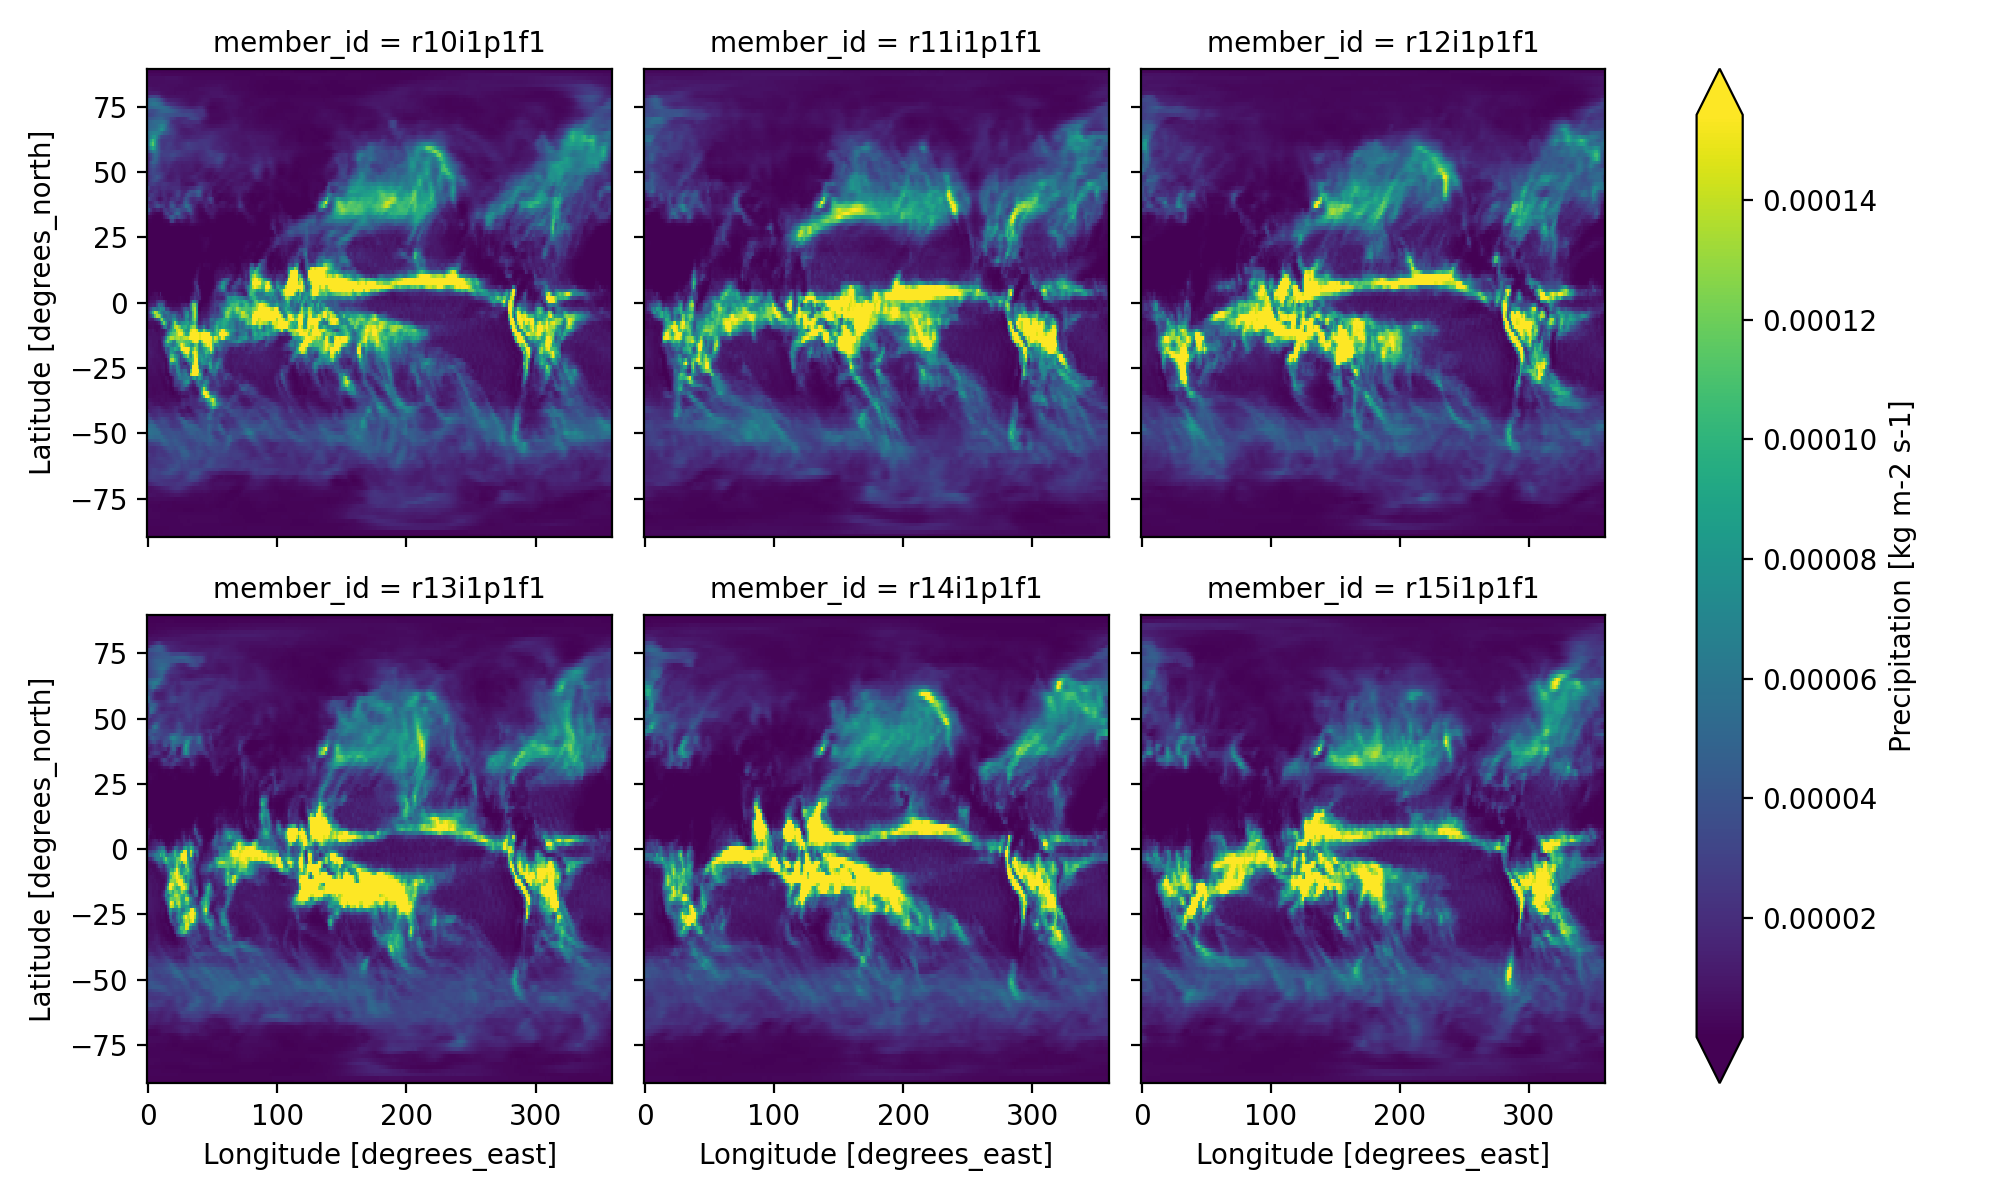

In [87]:
#Global historical Precipitation Flux Ensembles in 1979-01
model_historical_ds.pr.isel(time=0, member_id=range(0, 6)).plot(col='member_id',
                                                          col_wrap=3,
                                                          robust=True)

plt.suptitle("MIROC Global Distribution of Pr in 1979-01 in Historical Ensemble", y=1.1)

plt.savefig('images/Global_historical_pr_ensemble', bbox_inches='tight', dpi=300)

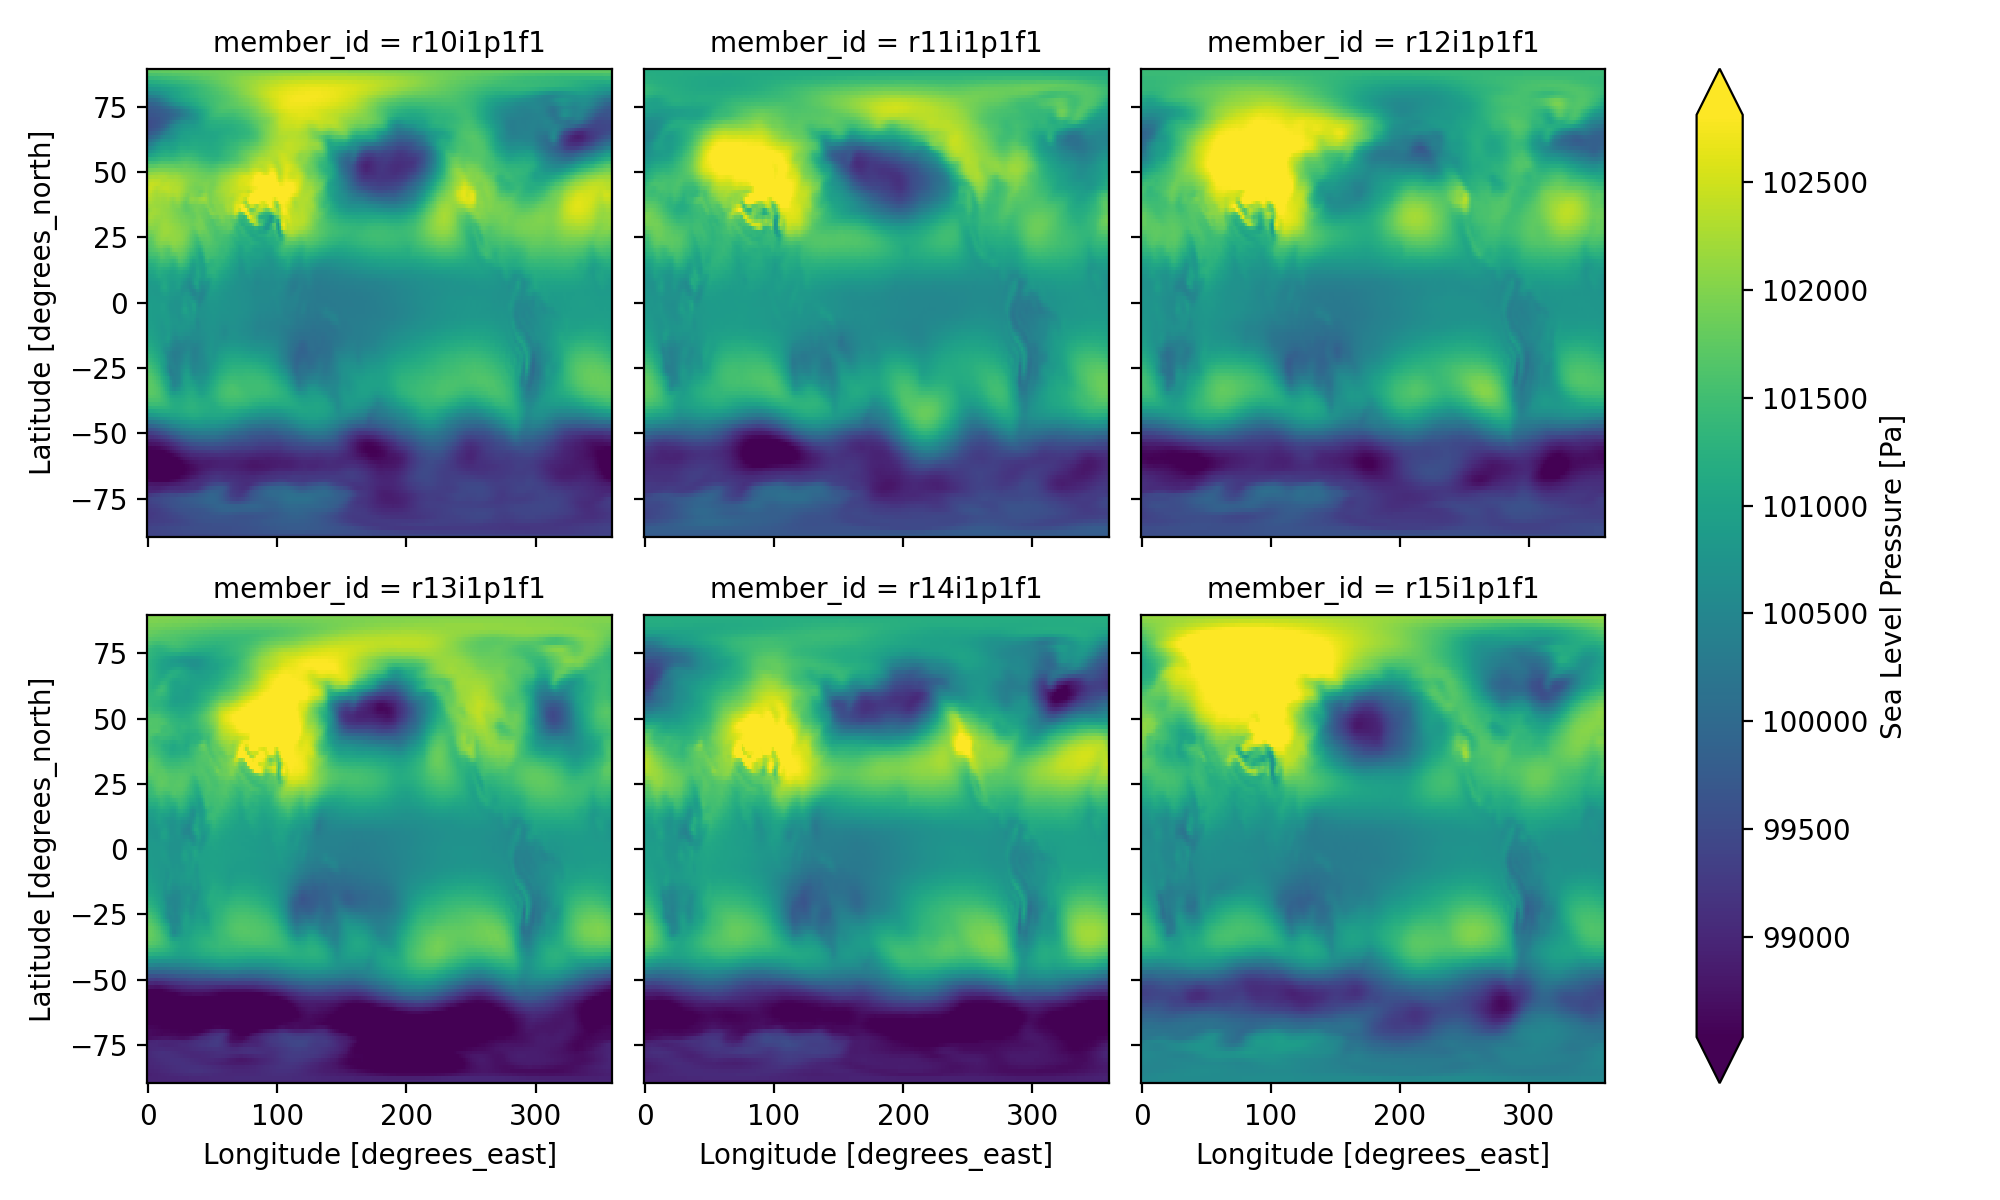

In [88]:
#Global historical Air Pressure at Sea Level Ensembles in 1979-01
model_historical_ds.psl.isel(time=0, member_id=range(0, 6)).plot(col='member_id',
                                                          col_wrap=3,
                                                          robust=True)

plt.suptitle("MIROC Global Distribution of Psl in 1979-01 in Historical Ensemble", y=1.1)

plt.savefig('images/Global_historical_psl_ensemble', bbox_inches='tight', dpi=300)

We now create some Robinson plots for the first ensemble member of each variable:

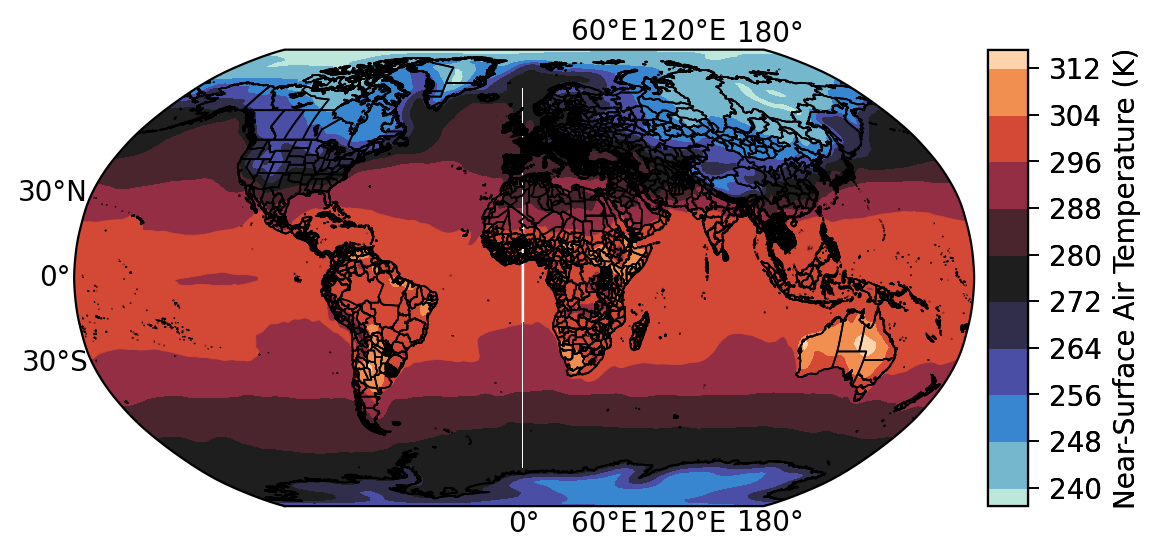

<Figure size 640x480 with 0 Axes>

In [63]:
#Create a Robinson projection with the proplot package
fig, ax = proplot.subplots(
    axwidth=4.5,
    tight=True,
    proj='robin',
    proj_kw={'lon_0': 0},
)

#Format options
ax.format(
    land=False,
    coast=True,
    innerborders=True,
    borders=True,
    labels=True,
    geogridlinewidth=0,
)

#Add contour variables
map1 = ax.contourf(model_historical_ds['lon'],
                   model_historical_ds['lat'],
                   #Choose ensemble member 0 and time 0
                   model_historical_ds['tas'][0, 0, :, :],
                   cmap='IceFire',
                   extend='both')

#Add a colorbar below
ax.colorbar(map1, loc='r', shrink=1, extendrect=True)

plt.show()

plt.savefig('images/Global_historical_tas_time0_member1', bbox_inches='tight', dpi=300)

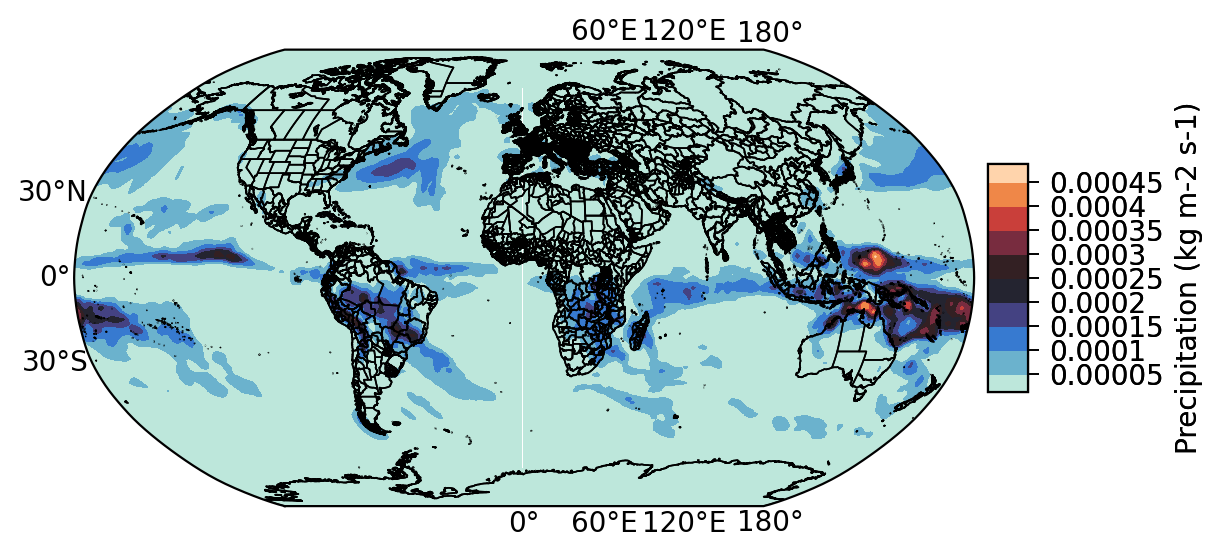

<Figure size 640x480 with 0 Axes>

In [64]:
#Create a Robinson projection with the proplot package
fig, ax = proplot.subplots(
    axwidth=4.5,
    tight=True,
    proj='robin',
    proj_kw={'lon_0': 0},
)

#Format options
ax.format(
    land=False,
    coast=True,
    innerborders=True,
    borders=True,
    labels=True,
    geogridlinewidth=0,
)

#Add contour variables
map1 = ax.contourf(model_historical_ds['lon'],
                   model_historical_ds['lat'],
                   #Choose ensemble member 0 and time 0
                   model_historical_ds['pr'][0, 0, :, :],
                   cmap='IceFire',
                   extend='both')

#Add a colorbar below
ax.colorbar(map1, loc='r', shrink=1, extendrect=True)

plt.show()

plt.savefig('images/Global_historical_pr_time0_member1', bbox_inches='tight', dpi=300)

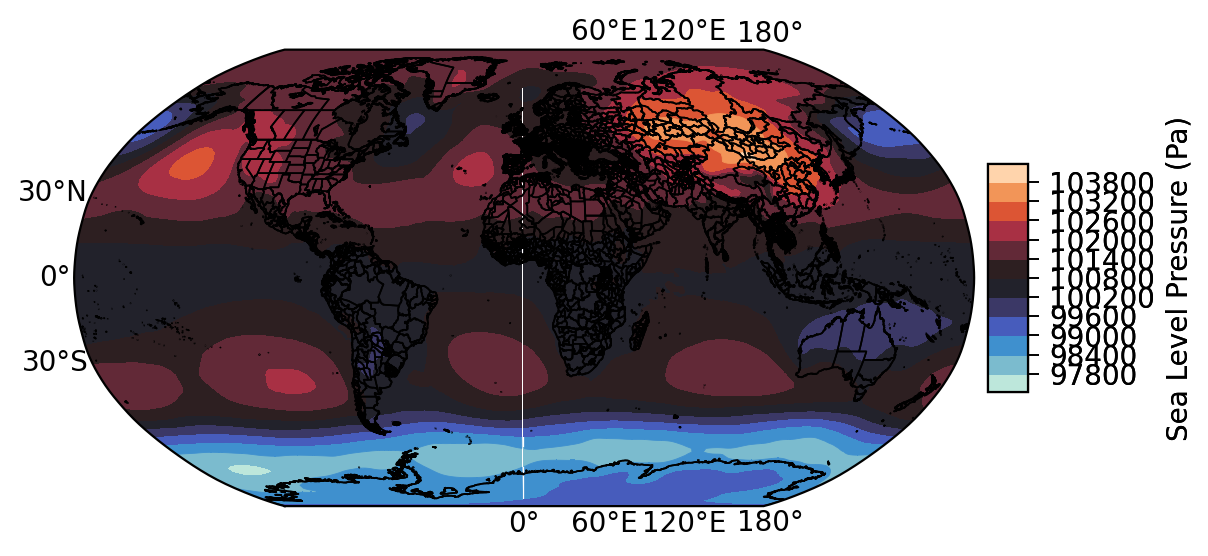

<Figure size 640x480 with 0 Axes>

In [65]:
#Create a Robinson projection with the proplot package
fig, ax = proplot.subplots(
    axwidth=4.5,
    tight=True,
    proj='robin',
    proj_kw={'lon_0': 0},
)

#Format options
ax.format(
    land=False,
    coast=True,
    innerborders=True,
    borders=True,
    labels=True,
    geogridlinewidth=0,
)

#Add contour variables
map1 = ax.contourf(model_historical_ds['lon'],
                   model_historical_ds['lat'],
                   #Choose ensemble member 0 and time 0
                   model_historical_ds['psl'][0, 0, :, :],
                   cmap='IceFire',
                   extend='both')

#Add a colorbar below
ax.colorbar(map1, loc='r', shrink=1, extendrect=True)

plt.show()

plt.savefig('images/Global_historical_psl_time0_member1', bbox_inches='tight', dpi=300)

### Australia

...and also an Australia based one:

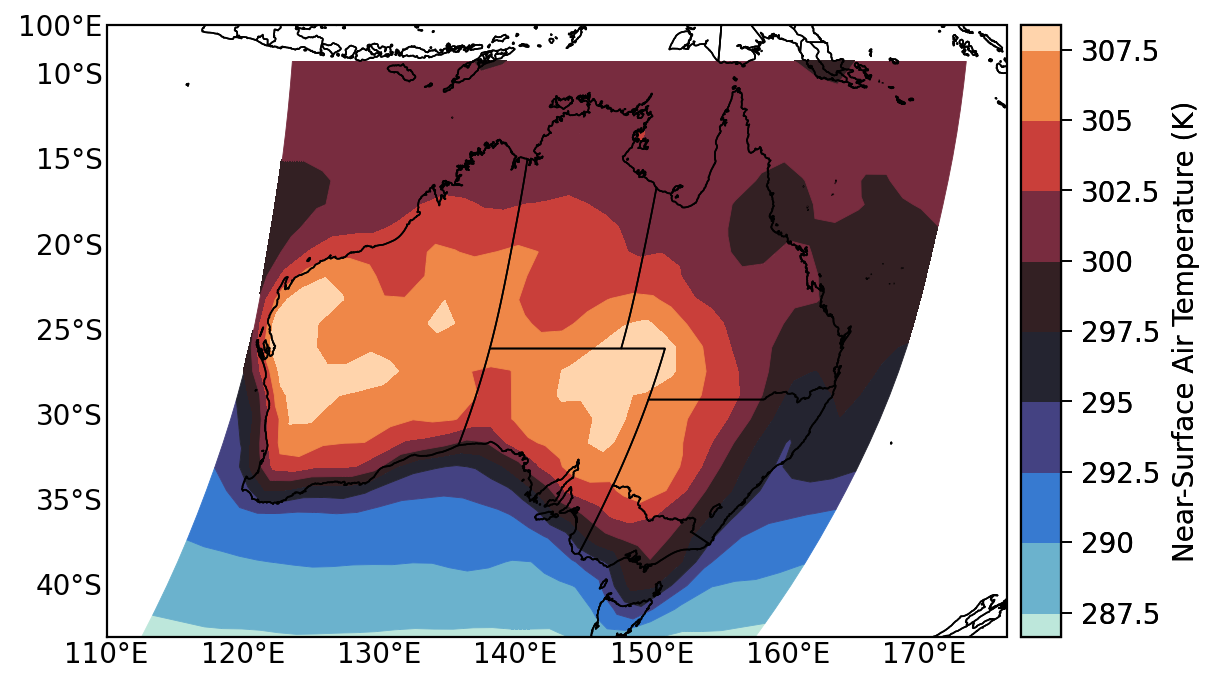

<Figure size 640x480 with 0 Axes>

In [14]:
#ensure the map is high quality
proplot.rc.reso = 'hi'

#create a Robinson projection with the proplot package
fig, ax = proplot.subplots(
    axwidth=4.5,
    tight=True,
    proj='robin',
    proj_kw={'lon_0': 0},
)

#format options
ax.format(
    land=False,
    coast=True,
    innerborders=True,
    borders=True,
    labels=True,
    geogridlinewidth=0,
)

ax[0].format(latlim=(-43, -7), lonlim=(110, 160), labels=True)

#add contour variables
map1 = ax.contourf(model_historical_A_tas_ds['lon'],
                   model_historical_A_tas_ds['lat'],
                   model_historical_A_tas_ds[0, 0, :, :],
                   cmap='IceFire',
                   extend='both')

#add a colorbar below
ax.colorbar(map1, loc='r', shrink=1, extendrect=True)

plt.show()

plt.savefig('images/Au_historical_tas', bbox_inches='tight', dpi=300)

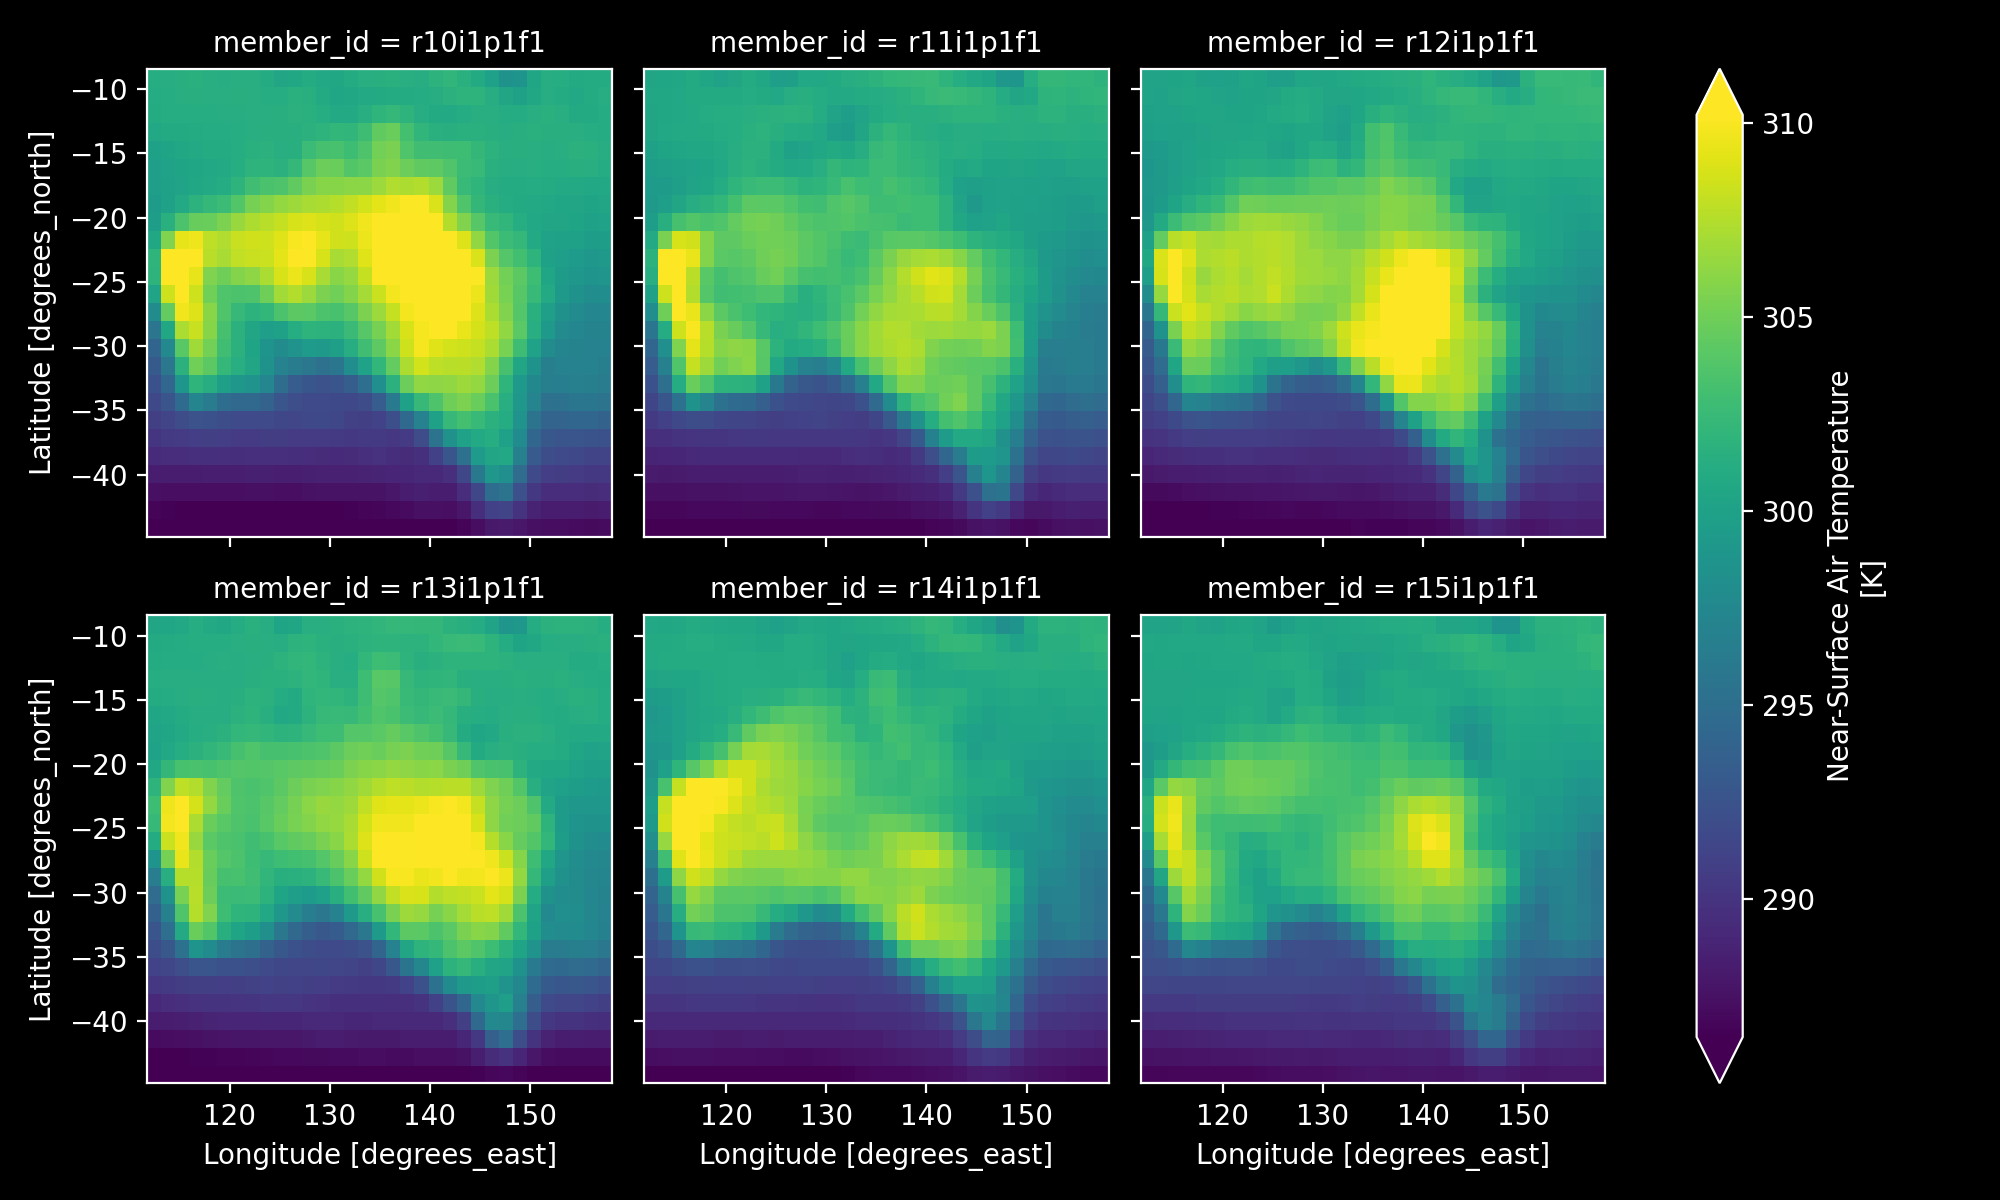

In [9]:
plt.style.use("dark_background")

#Australia historical Near-Surface Temperature Ensembles in 1850-01
model_historical_A_tas_ds.isel(time=0, member_id=range(0, 6)).plot(col='member_id',
                                                          col_wrap=3,
                                                          robust=True)

plt.suptitle("MIROC Australia Distribution of Tas in 1979-01 in Historical Ensemble", y=1.1)

plt.savefig('images/Au_historical_tas_ensemble_dark', bbox_inches='tight', dpi=300, transparency=True)

# Creating Probability Distributions

We will use the following algorithm to generate a probability distribution for the tas variable in each experiment:
<br> (1): Match the time-span that each experiment covers.
<br> (2): Across the first ten years and the last ten years of the simulation, calculate the global mean tas for each member of the ensemble.
<br> (3): Calculate the difference in this mean.
<br> (4): Normalise the data and plot as a histogram.

## General Function

We create a function that calculates the mean difference in tas, or any other variable for that matter, given the starting time, final time, number of members in the ensemble, and the experiment type. 
<br>As this code normally takes a long time to run, we use parallelisation to speed this up. We also save the output array as a text file that we can load in after:

In [8]:
def change_mean(model, initialTime, totalTime, totalMembers, experiment, variable):
    
    #Calculate 10 years in months
    firstTenYears = range(initialTime, initialTime+12*10)
    lastTenYears = range(totalTime-12*10,totalTime)
    
    def _calculate_means(member):
        first_mean_var = np.mean(model[member, firstTenYears, :, :])
        last_mean_var = np.mean(model[member, lastTenYears, :, :])
        return first_mean_var, last_mean_var


    #Get the results 
    results = Parallel(n_jobs=-1)(
        delayed(_calculate_means)(member) for member in range(totalMembers)
    )
    results = np.array(results)
    
    first_mean_var = results[:, 0]
    last_mean_var = results[:, 1]
    change_mean_var = last_mean_var - first_mean_var
    
    #Save the array as a txt file:
    np.savetxt('arrays/change_mean_'+experiment+'_'+variable+'.txt', change_mean_var)
    
    #Return the array as well
    return change_mean_var

## Historical Ensemble

In [9]:
totalTime = len(model_historical_A_tas_ds[0,:,0,0])

In [10]:
totalHistMembers = len(model_historical_A_tas_ds[:,0,0,0])

### Tas

In [11]:
%%time
change_mean_historical_tas = change_mean(model=model_historical_A_tas_ds,
                                         initialTime=0,
                                         totalTime=totalTime,
                                         totalMembers=totalHistMembers,
                                         experiment='historical',
                                         variable='tas')

Wall time: 17min 54s


Run the following code if you have already run the function above:

In [2]:
change_mean_historical_tas = np.loadtxt('arrays/change_mean_historical_tas.txt')

Now we have an array of the mean temperature change in each ensemble member:

In [12]:
change_mean_historical_tas

array([0.5295105 , 0.6755676 , 0.7010193 , 0.5061035 , 0.80422974,
       0.4675598 , 0.62750244, 0.75613403, 0.5758362 , 0.5790405 ,
       0.7966919 , 0.5739136 , 0.5974121 , 0.5605469 , 0.61605835,
       0.54537964, 0.54452515, 0.5899353 , 0.8404236 , 0.6459961 ,
       0.62335205, 0.49499512, 0.72683716, 0.63079834, 0.5566101 ,
       0.43417358, 0.5340271 , 0.5896301 , 0.5230713 , 0.48712158,
       0.43188477, 0.78616333, 0.6147156 , 0.683197  , 0.7029724 ,
       0.6659851 , 0.83496094, 0.68618774, 0.43029785, 0.54696655,
       0.69714355, 0.67614746, 0.5629883 , 0.5807495 , 0.91116333,
       0.7287903 , 0.5079956 , 0.6994629 , 0.63861084, 0.7045288 ],
      dtype=float32)

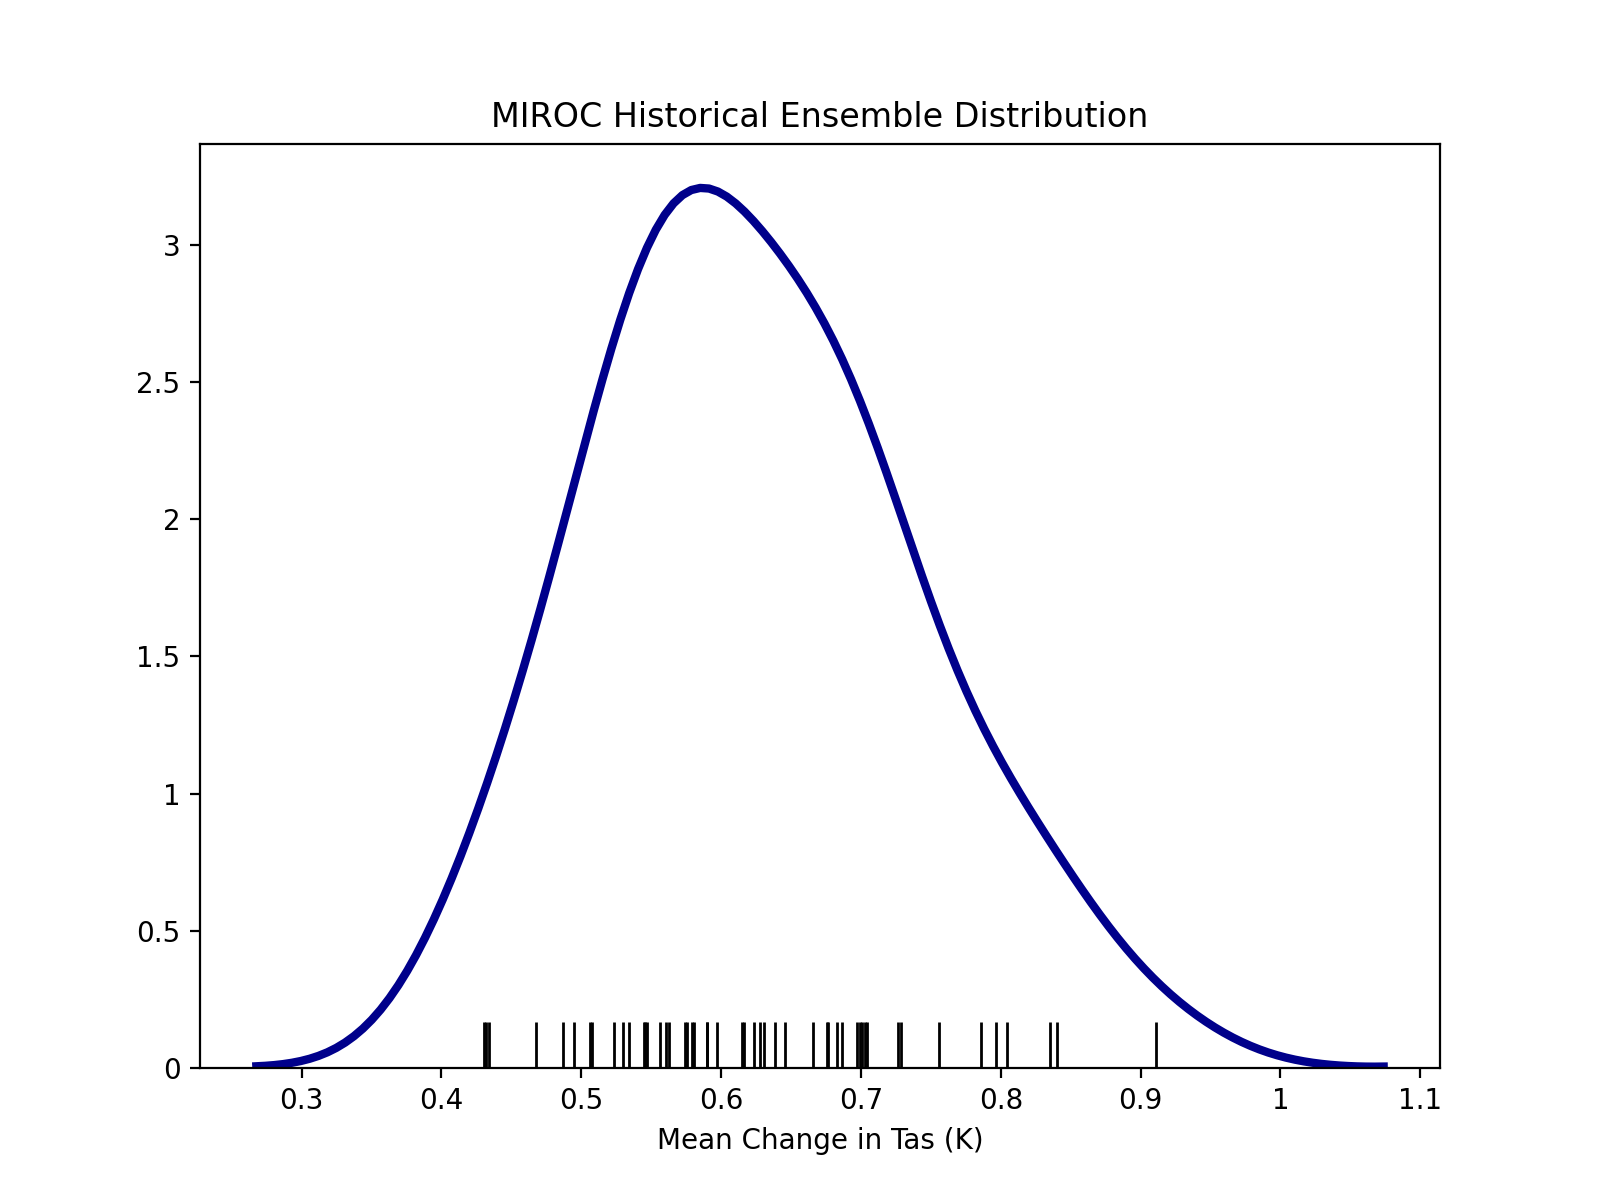

In [16]:
#Create a rug plot
fig, ax = plt.subplots(figsize=(8, 6))

sns.distplot(change_mean_historical_tas, hist=False, kde=True, rug=True, color='darkblue', 
            kde_kws={'linewidth': 3}, rug_kws={'color': 'black'})

plt.xlabel('Mean Change in Tas (K)')
plt.title('MIROC Historical Ensemble Distribution')
plt.savefig('images/Historical_ensemble_tas_dist', bbox_inches='tight', dpi=300)

### Pr

We repeat this process above for each of the other two variables pr and psl:

In [15]:
%%time
change_mean_historical_pr = change_mean(model=model_historical_A_pr_ds,
                                         initialTime=0,
                                         totalTime=totalTime,
                                         totalMembers=totalHistMembers,
                                         experiment='historical',
                                         variable='pr')

Wall time: 18min 50s


In [3]:
change_mean_historical_pr = np.loadtxt('arrays/change_mean_historical_pr.txt')

In [13]:
change_mean_historical_pr

array([ 4.65413905e-07, -2.03793752e-06, -1.28857573e-06, -1.55371890e-06,
       -2.35284460e-06, -2.14444299e-07,  3.06970105e-06, -1.07105734e-06,
       -6.88007276e-07,  1.26458326e-06, -1.99403439e-06,  2.53687176e-07,
       -8.88067007e-07,  6.68431312e-07,  1.02477134e-06, -3.61236744e-07,
        1.74333400e-06,  1.15204239e-06, -3.19995161e-06, -3.85727617e-07,
        1.99845817e-06,  2.99421299e-06, -2.22350718e-06, -5.06934157e-07,
        3.75737727e-07,  1.47483661e-06,  4.56457201e-07,  7.67449819e-07,
       -1.16946467e-06,  3.24295252e-06,  2.82188194e-06, -3.69462214e-06,
        1.10402834e-06,  8.22707079e-07, -6.09466952e-07, -6.46406988e-07,
       -4.36600385e-06, -3.42704880e-07,  3.30916009e-06,  9.44037311e-07,
        3.01769251e-06, -1.72518776e-06,  2.13846215e-06, -1.68234692e-06,
       -1.66050813e-06, -1.88773993e-06,  1.50309643e-06, -2.42525130e-06,
       -1.20152254e-06,  2.35404514e-06])

We notice that these values are particularly small due to the units of $kg m^{-2}s^{-1}$, which will cause problems in the future. So, we scale up these values to $g m^{-2}d^{-1}$, which equates to scaling up by a value of:
$$ 1000 * (24 * 60^2) = 8.64 x 10^{7} $$

In [4]:
change_mean_historical_pr *= (8.63e7)
change_mean_historical_pr

array([  40.16521998, -175.87400798, -111.20408562, -134.08594132,
       -203.05048929,  -18.50654298,  264.91520075,  -92.43224849,
        -59.37502792,  109.13353544, -172.08516801,   21.8932033 ,
        -76.64018267,   57.68562223,   88.43776632,  -31.17473098,
        150.44972388,   99.42125798, -276.15582367,  -33.28829334,
        172.46694042,  258.40058115, -191.88866972,  -43.74841774,
         32.42616585,  127.2783993 ,   39.39225644,   66.2309194 ,
       -100.92480079,  279.86680216,  243.52841101, -318.84589043,
         95.27764596,   70.99962095,  -52.59699792,  -55.7849231 ,
       -376.78613226,  -29.57543111,  285.58051599,   81.4704199 ,
        260.42686331, -148.88370351,  184.54928359, -145.18653916,
       -143.30185186, -162.9119557 ,  129.71722172, -209.29918683,
       -103.69139491,  203.15409529])

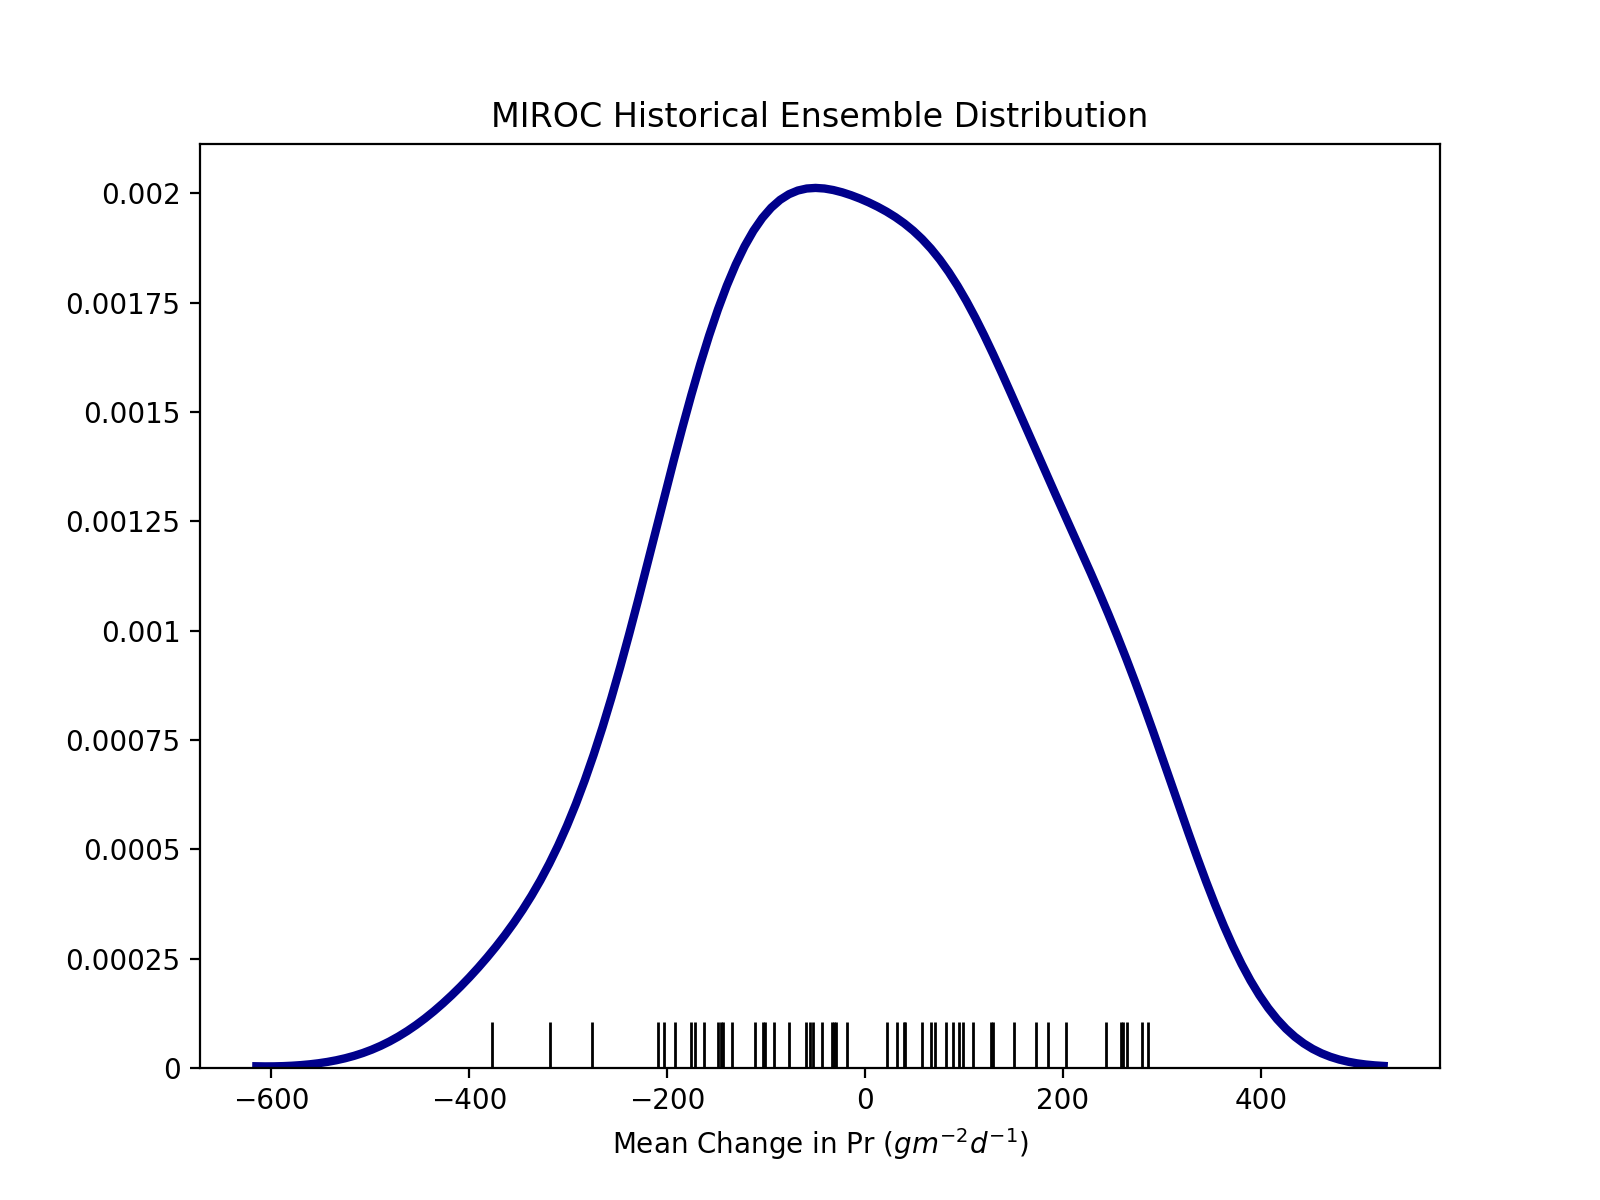

In [34]:
#Create a rug plot
fig, ax = plt.subplots(figsize=(8, 6))

sns.distplot(change_mean_historical_pr, hist=False, kde=True, rug=True, color='darkblue', 
            kde_kws={'linewidth': 3}, rug_kws={'color': 'black'})

plt.xlabel('Mean Change in Pr ($g m^{-2} d^{-1}$)')
plt.title('MIROC Historical Ensemble Distribution')
plt.savefig('images/Historical_ensemble_pr_dist', bbox_inches='tight', dpi=300)

### Psl

In [18]:
%%time
change_mean_historical_psl = change_mean(model=model_historical_A_psl_ds,
                                         initialTime=0,
                                         totalTime=totalTime,
                                         totalMembers=totalHistMembers,
                                         experiment='historical',
                                         variable='psl')

Wall time: 19min 45s


In [5]:
change_mean_historical_psl = np.loadtxt('arrays/change_mean_historical_psl.txt')

In [19]:
change_mean_historical_psl

array([ 26.78125 ,  34.375   ,  49.796875,  72.640625,  38.265625,
        34.742188,  17.039062,  74.92969 ,  57.367188,  54.953125,
        79.52344 , -14.1875  ,  41.4375  ,  97.078125,  59.34375 ,
        89.046875,  58.640625,  68.58594 ,  84.625   ,  40.78125 ,
        24.171875,  58.890625,  90.78906 ,   4.96875 ,  42.164062,
        54.179688,  72.10156 ,  25.390625,  57.765625,  19.054688,
        64.94531 ,  86.36719 ,  77.171875,  33.570312,  55.8125  ,
        57.9375  ,  62.015625, 110.75781 ,  53.796875,  47.351562,
        43.507812,  39.96875 ,  32.671875,  43.859375, -15.375   ,
        59.429688,  79.92969 ,  70.140625,  88.5625  ,  68.671875],
      dtype=float32)

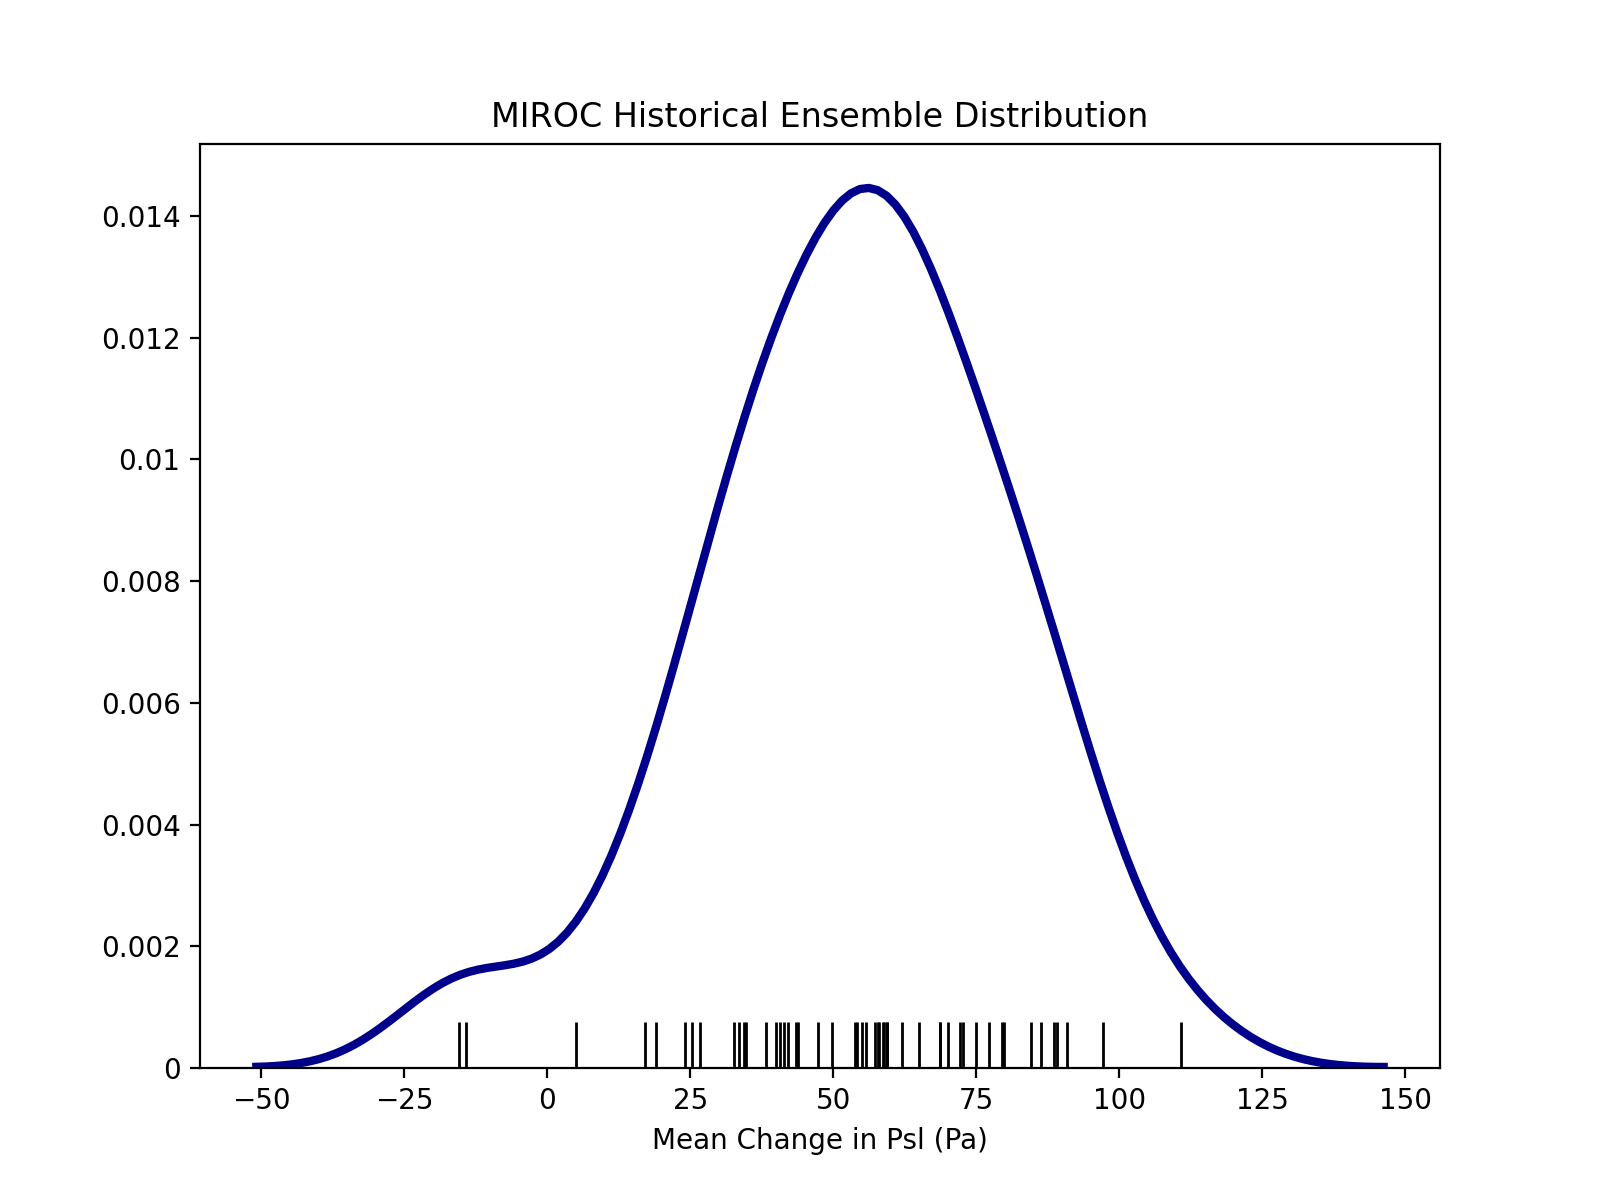

In [19]:
#Create a rug plot
fig, ax = plt.subplots(figsize=(8, 6))

sns.distplot(change_mean_historical_psl, hist=False, kde=True, rug=True, color='darkblue', 
            kde_kws={'linewidth': 3}, rug_kws={'color': 'black'})

plt.xlabel('Mean Change in Psl (Pa)')
plt.title('MIROC Historical Ensemble Distribution')
plt.savefig('images/Historical_ensemble_psl_dist', bbox_inches='tight', dpi=300, edgecolor='none')

## AMIP Ensemble

We repeat this for the AMIP ensemble.

### Tas

In [21]:
totalTime = len(model_amip_A_tas_ds[0,:,0,0])

In [22]:
totalAMIPMembers = len(model_amip_A_tas_ds[:,0,0,0])

In [23]:
%%time
change_mean_amip_tas = change_mean(model=model_amip_A_tas_ds,
                                         initialTime=0,
                                         totalTime=totalTime,
                                         totalMembers=totalAMIPMembers,
                                         experiment='amip',
                                         variable='tas')

Wall time: 3min 10s


Run the following code if you have already run the function above:

In [6]:
change_mean_amip_tas = np.loadtxt('arrays/change_mean_amip_tas.txt')

Now we have an array of the mean temperature change in each ensemble member:

In [24]:
change_mean_amip_tas

array([ 0.44903564,  0.4498291 ,  0.23098755,  0.288208  ,  0.40570068,
        0.3395691 ,  0.55493164, -0.01565552,  0.38031006,  0.38912964],
      dtype=float32)

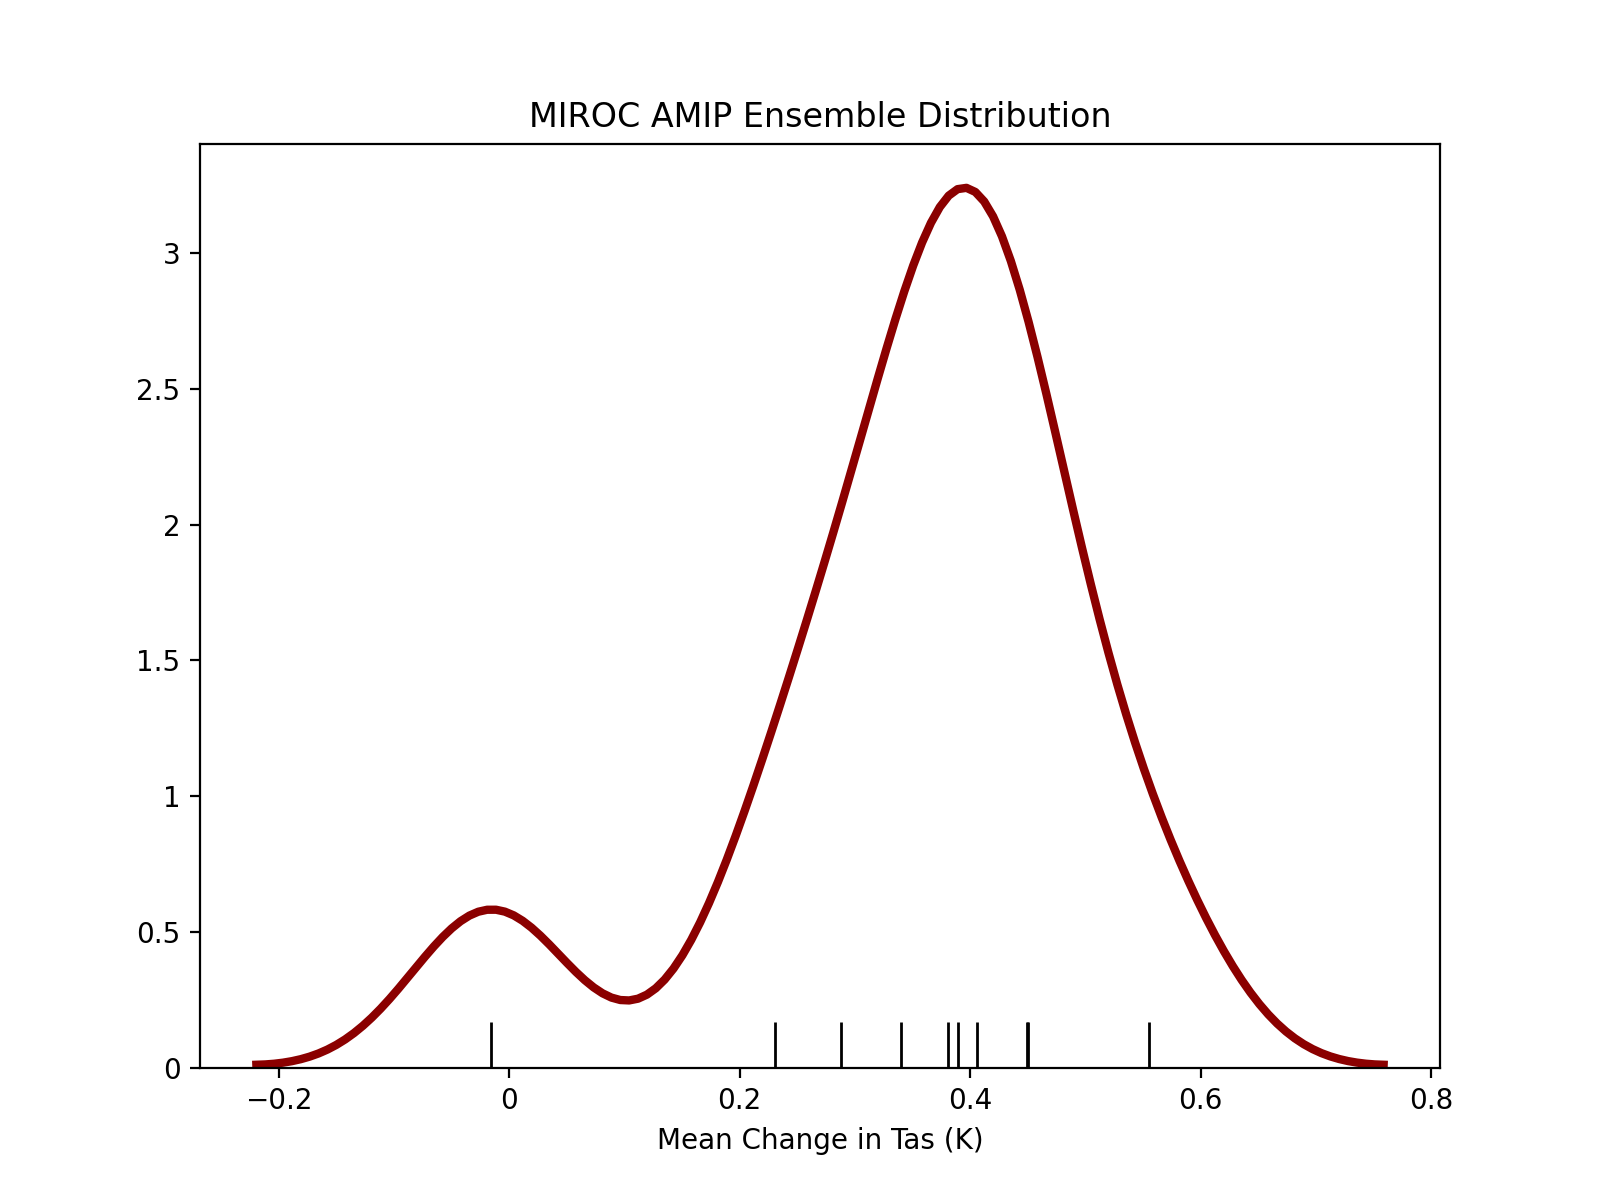

In [80]:
#Create a rug plot
fig, ax = plt.subplots(figsize=(8, 6))

sns.distplot(change_mean_amip_tas, hist=False, kde=True, rug=True, color='darkred', 
            kde_kws={'linewidth': 3}, rug_kws={'color': 'black'})

plt.xlabel('Mean Change in Tas (K)')
plt.title('MIROC AMIP Ensemble Distribution')

plt.savefig('images/AMIP_ensemble_tas_dist', bbox_inches='tight', dpi=300)

### Pr

In [26]:
%%time
change_mean_amip_pr = change_mean(model=model_amip_A_pr_ds,
                                         initialTime=0,
                                         totalTime=totalTime,
                                         totalMembers=totalAMIPMembers,
                                         experiment='amip',
                                         variable='pr')

Wall time: 3min 45s


In [7]:
change_mean_amip_pr = np.loadtxt('arrays/change_mean_amip_pr.txt')

In [27]:
change_mean_amip_pr

array([ 1.3779245e-06,  1.0224612e-06,  1.4470115e-06,  2.4073597e-07,
        8.9337300e-07,  3.0257015e-06, -1.5963051e-06,  3.9094430e-06,
       -7.5182834e-07,  3.8401504e-06], dtype=float32)

We notice that these values are particularly small due to the units of $kg m^{-2}s^{-1}$, which will cause problems in the future. So, we scale up these values to $g m^{-2}d^{-1}$, which equates to scaling up by a value of:
$$ 1000 * (24 * 60^2) = 8.64 * 10^{7} $$

In [8]:
change_mean_amip_pr *= (8.63e7)
change_mean_amip_pr

array([ 118.91488357,   88.23840326,  124.87709482,   20.77551435,
         77.09808979,  261.11804091, -137.76112864,  337.38492803,
        -64.88278559,  331.40497817])

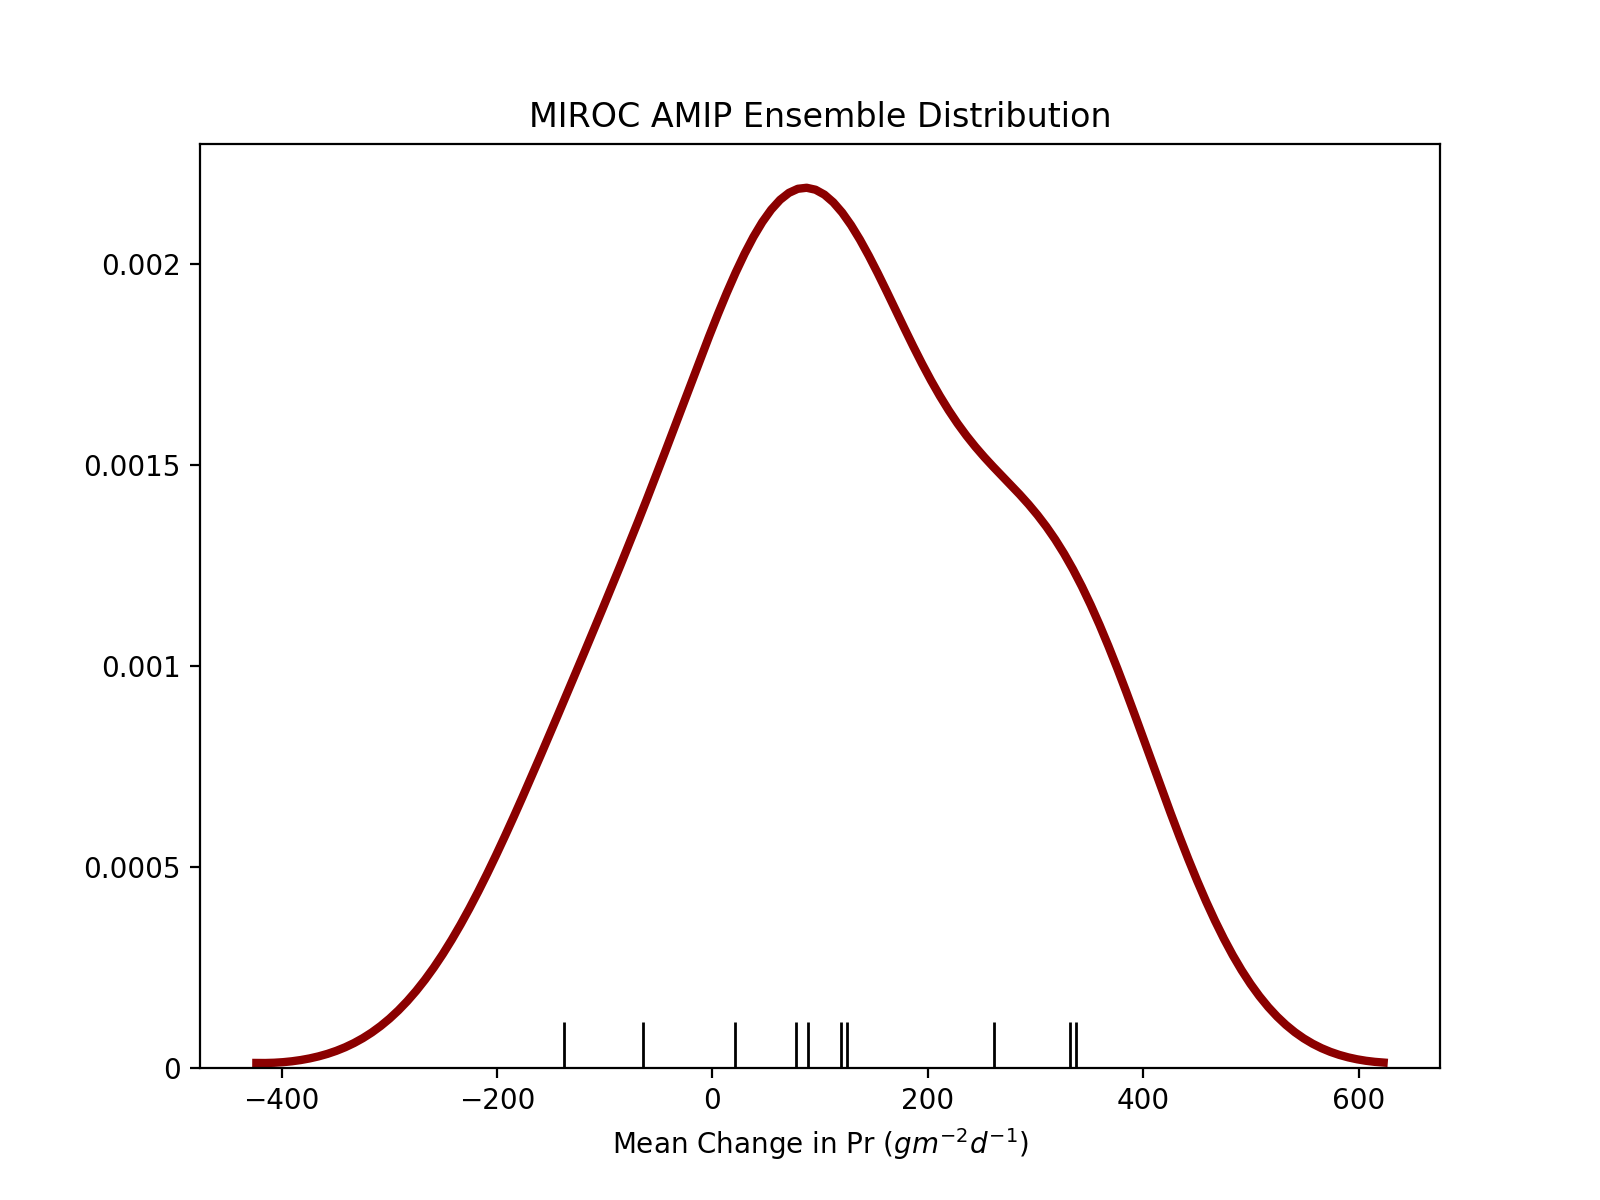

In [81]:
#Create a rug plot
fig, ax = plt.subplots(figsize=(8, 6))

sns.distplot(change_mean_amip_pr, hist=False, kde=True, rug=True, color='darkred', 
            kde_kws={'linewidth': 3}, rug_kws={'color': 'black'})

plt.xlabel('Mean Change in Pr ($g m^{-2} d^{-1}$)')
plt.title('MIROC AMIP Ensemble Distribution')

plt.savefig('images/AMIP_ensemble_pr_dist', bbox_inches='tight', dpi=300)

### Psl

In [29]:
%%time
change_mean_amip_psl = change_mean(model=model_amip_A_psl_ds,
                                         initialTime=0,
                                         totalTime=totalTime,
                                         totalMembers=totalAMIPMembers,
                                         experiment='amip',
                                         variable='psl')

Wall time: 2min 29s


In [9]:
change_mean_amip_psl = np.loadtxt('arrays/change_mean_amip_psl.txt')

In [30]:
change_mean_amip_psl

array([-10.09375  , -35.9375   ,  17.242188 ,  -3.7421875, -26.375    ,
       -43.9375   ,  -5.5859375, -37.8125   ,  -9.8359375, -49.242188 ],
      dtype=float32)

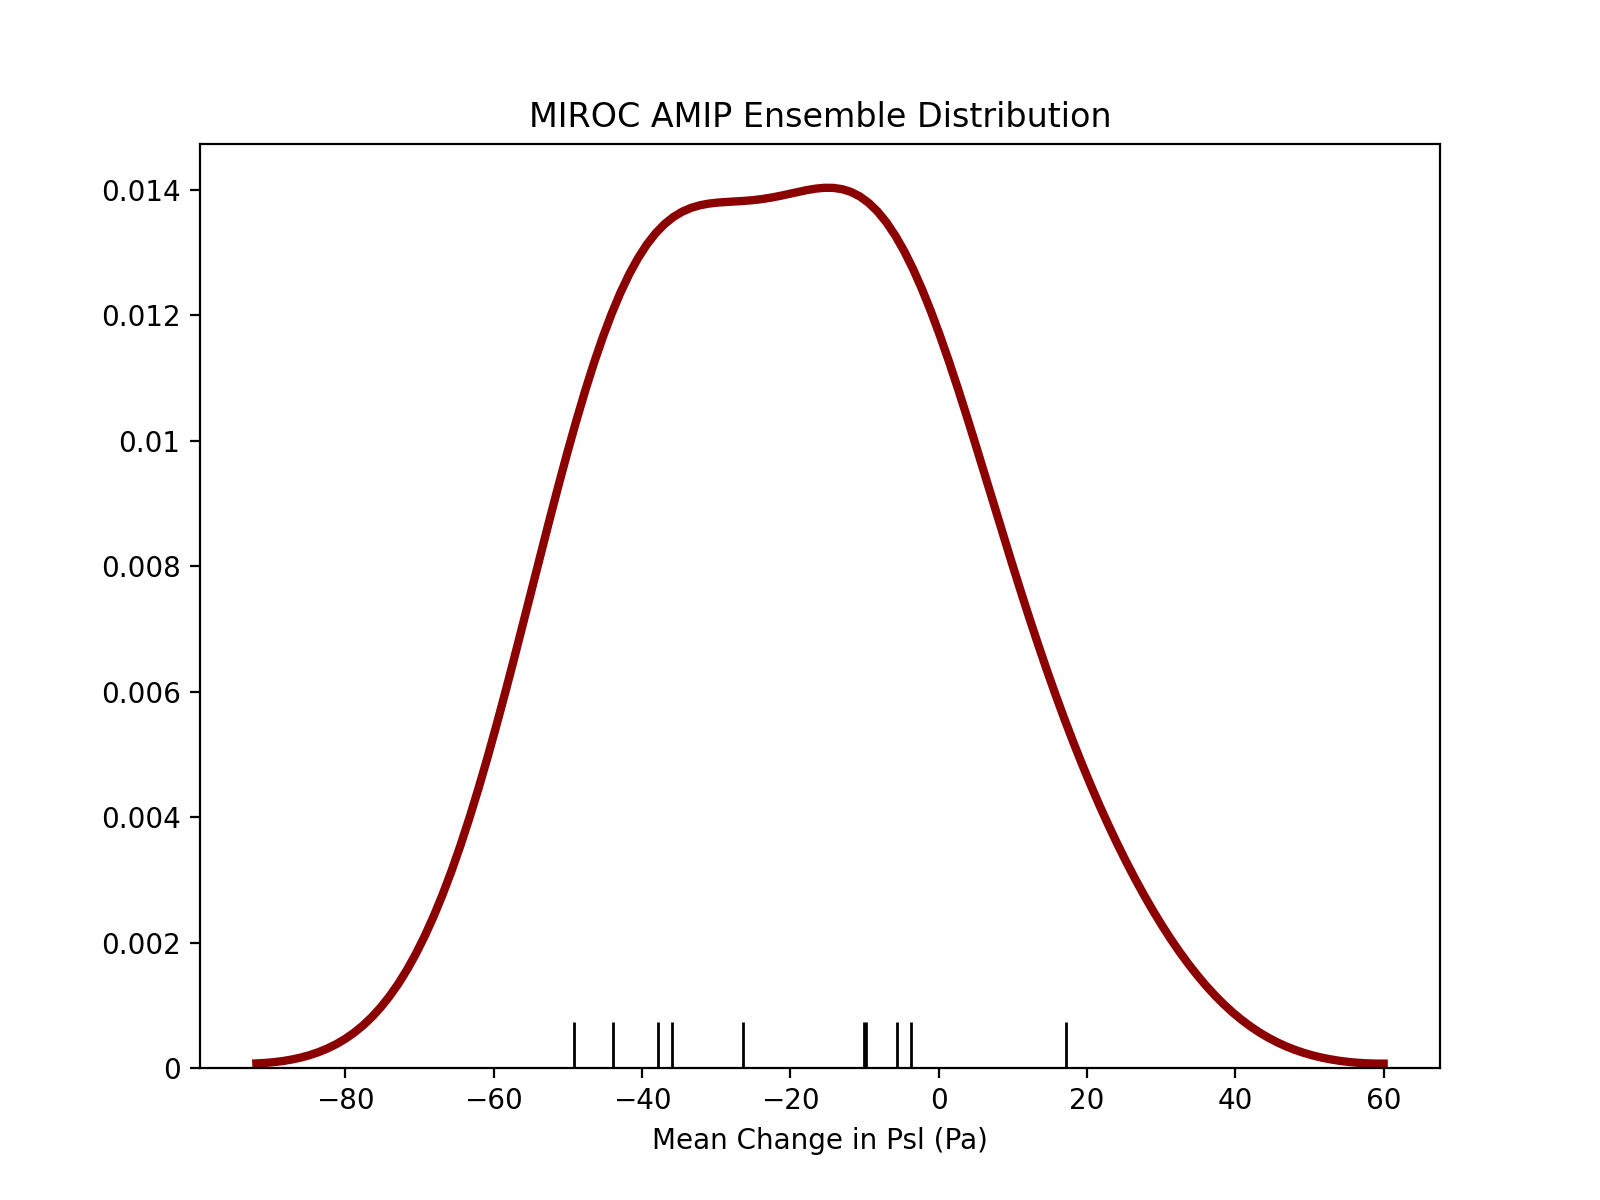

In [82]:
#Create a rug plot 
fig, ax = plt.subplots(figsize=(8, 6))

sns.distplot(change_mean_amip_psl, hist=False, kde=True, rug=True, color='darkred', 
            kde_kws={'linewidth': 3}, rug_kws={'color': 'black'})

plt.xlabel('Mean Change in Psl (Pa)')
plt.title('MIROC AMIP Ensemble Distribution')

plt.savefig('images/AMIP_ensemble_psl_dist', bbox_inches='tight', dpi=300)

# Calculating Distances in 3D

In [ ]:
#Mathematical and statistical packages
import math
import scipy

#KL
from scipy.stats import entropy

#JS
from scipy.spatial.distance import jensenshannon

#Wasserstein
import ot
import ot.plot

#Energy
import dcor

## Creating Joint Distribution

We re-apply the process above, but for all three variables at once. Hence we need to create the two three-variate array distributions for a distance to be calculated:

In [10]:
historical_outputs = np.dstack([change_mean_historical_tas, change_mean_historical_pr, change_mean_historical_psl])[0,:,:]
historical_outputs.shape

(50, 3)

In [11]:
amip_outputs = np.dstack([change_mean_amip_tas, change_mean_amip_pr, change_mean_amip_psl])[0,:,:]
amip_outputs.shape

(10, 3)

We see that these both have shape (number of amip ensembles, number of variables).

In [12]:
np.savetxt('arrays/all_historical_outputs.txt', historical_outputs)

In [5]:
historical_outputs = np.loadtxt('arrays/all_historical_outputs.txt')
historical_outputs

array([[   0.5295105 ,   40.16521998,   26.78125   ],
       [   0.67556763, -175.87400798,   34.375     ],
       [   0.70101929, -111.20408562,   49.796875  ],
       [   0.50610352, -134.08594132,   72.640625  ],
       [   0.80422974, -203.05048929,   38.265625  ],
       [   0.46755981,  -18.50654298,   34.7421875 ],
       [   0.62750244,  264.91520075,   17.0390625 ],
       [   0.75613403,  -92.43224849,   74.9296875 ],
       [   0.57583618,  -59.37502792,   57.3671875 ],
       [   0.57904053,  109.13353544,   54.953125  ],
       [   0.79669189, -172.08516801,   79.5234375 ],
       [   0.57391357,   21.8932033 ,  -14.1875    ],
       [   0.59741211,  -76.64018267,   41.4375    ],
       [   0.56054688,   57.68562223,   97.078125  ],
       [   0.61605835,   88.43776632,   59.34375   ],
       [   0.54537964,  -31.17473098,   89.046875  ],
       [   0.54452515,  150.44972388,   58.640625  ],
       [   0.5899353 ,   99.42125798,   68.5859375 ],
       [   0.84042358, -276.

In [14]:
np.savetxt('arrays/all_amip_outputs.txt', amip_outputs)

In [3]:
amip_outputs = np.loadtxt('arrays/all_amip_outputs.txt')
amip_outputs

array([[ 4.49035645e-01,  1.18914884e+02, -1.00937500e+01],
       [ 4.49829102e-01,  8.82384033e+01, -3.59375000e+01],
       [ 2.30987549e-01,  1.24877095e+02,  1.72421875e+01],
       [ 2.88208008e-01,  2.07755143e+01, -3.74218750e+00],
       [ 4.05700684e-01,  7.70980898e+01, -2.63750000e+01],
       [ 3.39569092e-01,  2.61118041e+02, -4.39375000e+01],
       [ 5.54931641e-01, -1.37761129e+02, -5.58593750e+00],
       [-1.56555176e-02,  3.37384928e+02, -3.78125000e+01],
       [ 3.80310059e-01, -6.48827856e+01, -9.83593750e+00],
       [ 3.89129639e-01,  3.31404978e+02, -4.92421875e+01]])

## Visualisation of the Joint Outputs

Let's see these outputs in a 3D projection plot:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

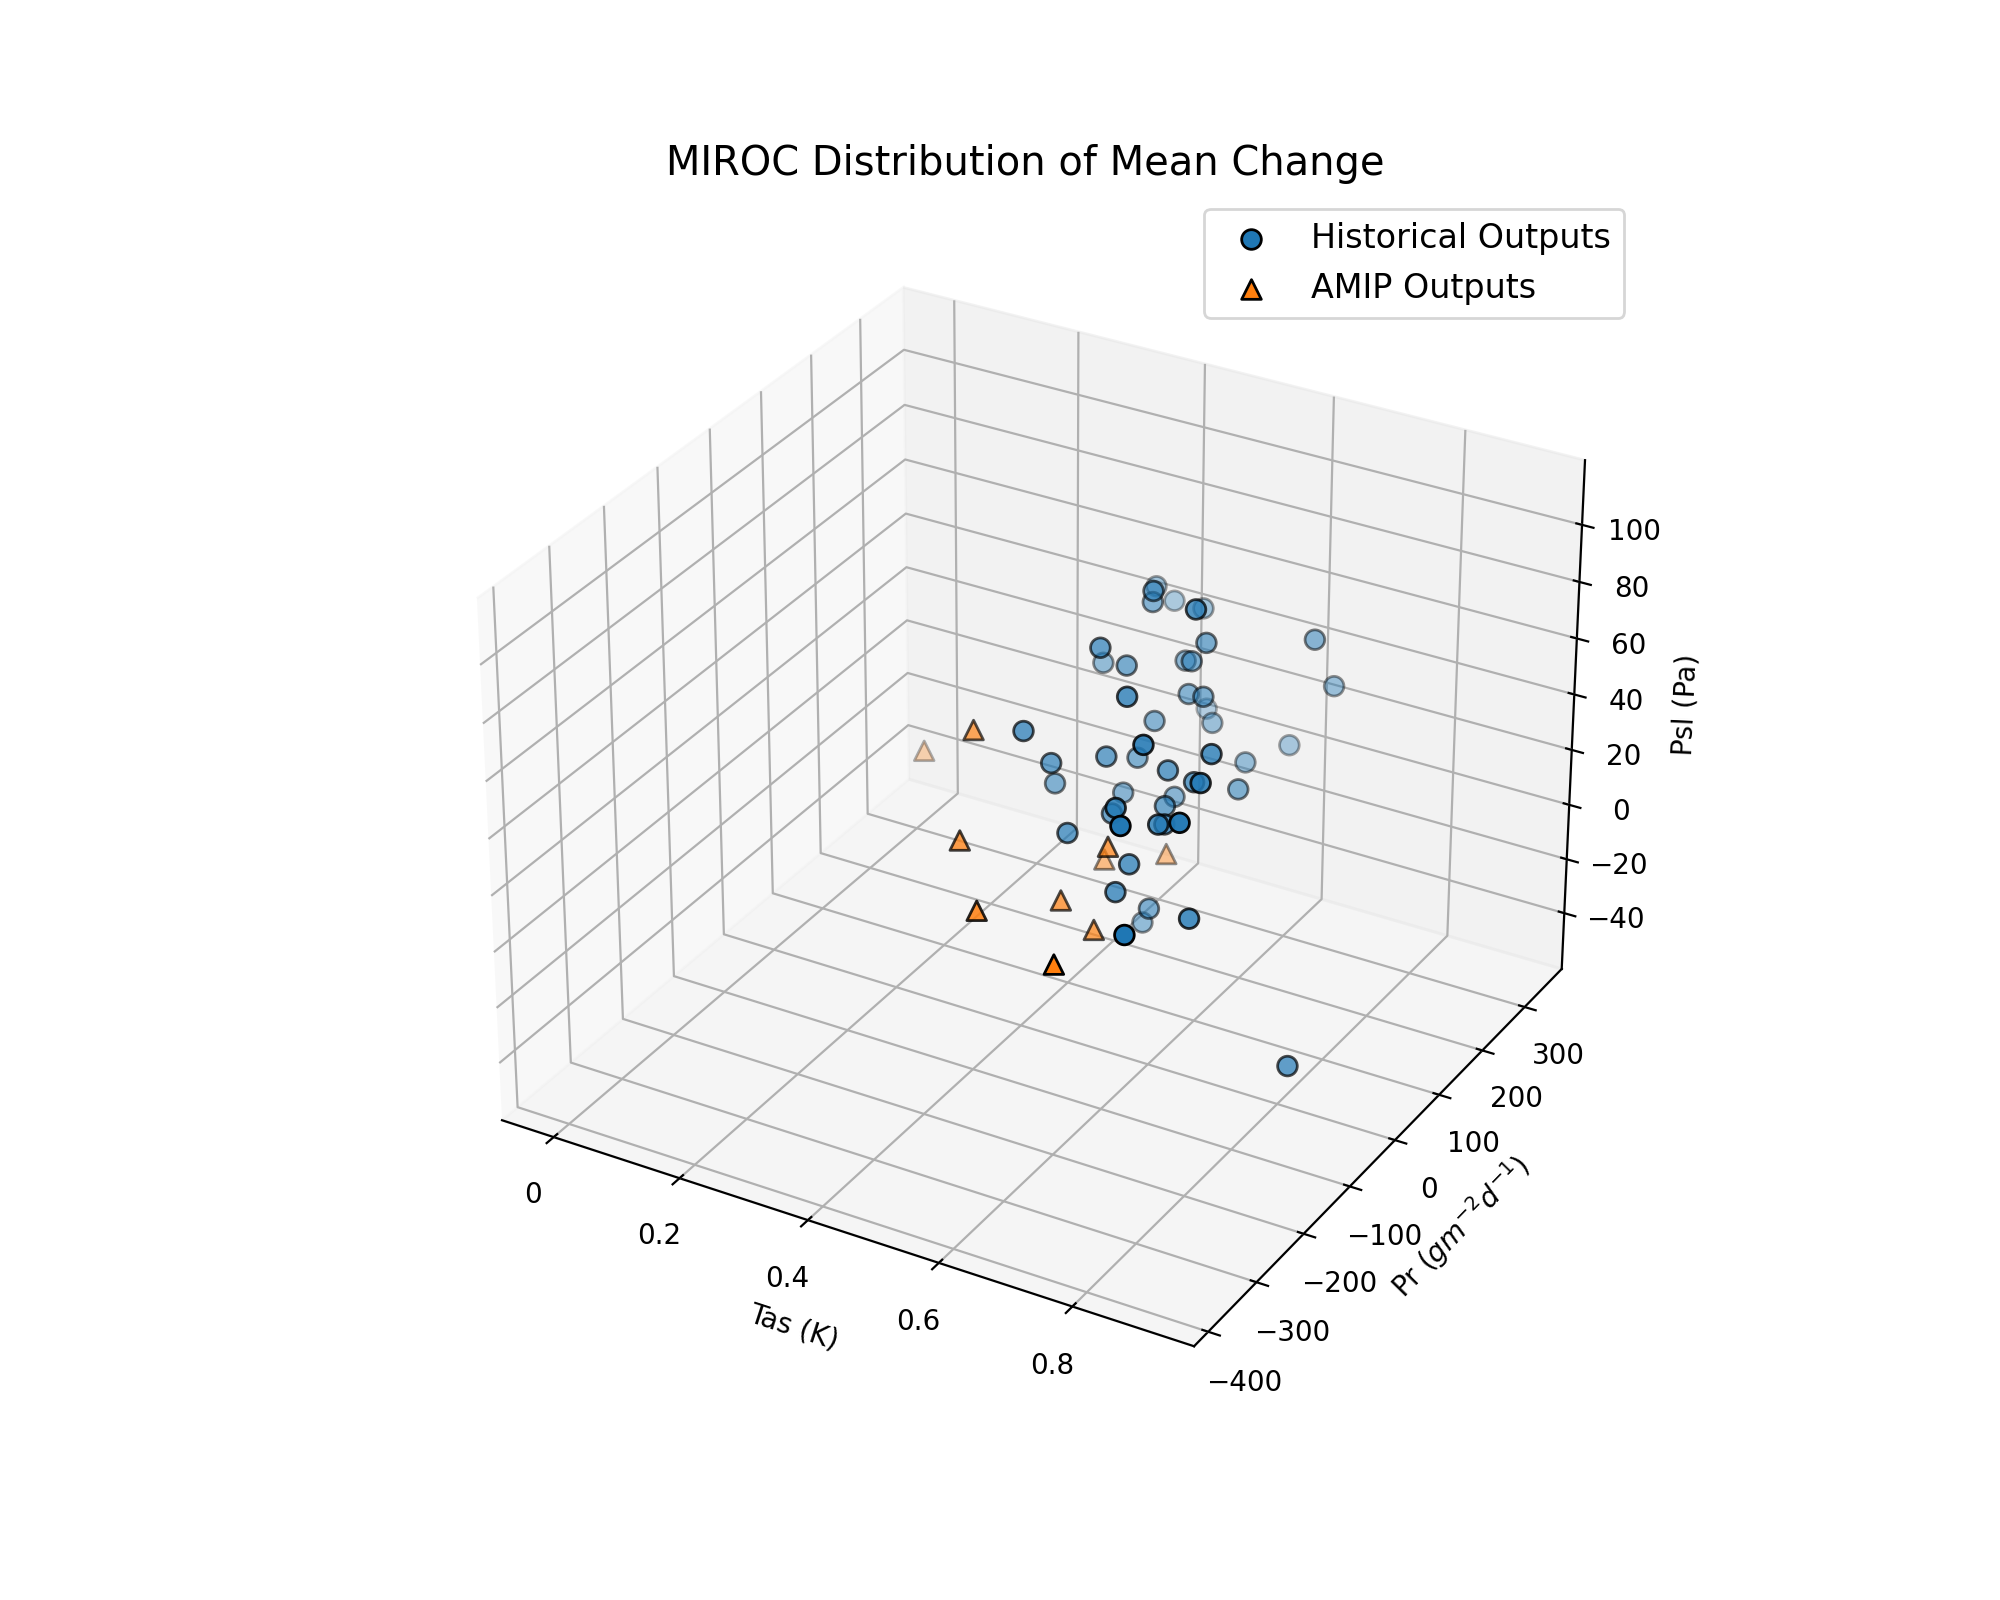

In [8]:
fig = plt.figure(figsize=(10,8))

#Make 3D projection
ax = plt.axes(projection='3d')
ax.scatter3D(historical_outputs[:,0], historical_outputs[:,1], historical_outputs[:,2], s=50, cmap='Greens', edgecolor='black', label='Historical Outputs')
ax.scatter3D(amip_outputs[:,0], amip_outputs[:,1], amip_outputs[:,2], s=50, cmap='Reds', marker= '^', edgecolor='black', label='AMIP Outputs')

ax.set_xlabel('Tas (K)')
ax.set_ylabel('Pr ($gm^{-2}d^{-1}$)')
ax.set_zlabel('Psl (Pa)')

ax.set_title('MIROC Distribution of Mean Change', fontsize='x-large')
plt.legend(fontsize='large')
fig.savefig('images/Tas_pr_prt_dist.eps', format='eps', bbox_inches='tight', dpi=300, transparency=True)

## Fitting a 3D Multivariate Gaussian to the Distributions

This will be necessary in order to calculate KL divergence (and JS distance) in a sensible way, as unlike Wasserstein and energy distance, KL divergence requires a 1D pdf for each measure, with a shared support (this is one of the limitations of KL divergence!). 

In [9]:
from scipy.stats import multivariate_normal

### Mean and Covariance

In [10]:
amip_mean = np.mean(amip_outputs, axis=0)
amip_cov = np.cov(amip_outputs, rowvar=0)

In [11]:
amip_mean

array([  0.34720459, 115.71680187, -20.53203125])

In [12]:
amip_cov

array([[ 2.43377902e-02, -1.45946398e+01,  2.73761993e-01],
       [-1.45946398e+01,  2.50023771e+04, -2.19022756e+03],
       [ 2.73761993e-01, -2.19022756e+03,  4.55301411e+02]])

In [13]:
historical_mean = np.mean(historical_outputs, axis=0)
historical_cov = np.cov(historical_outputs, rowvar=0)

In [14]:
historical_mean

array([ 0.62449829, -2.0886153 , 53.52671875])

In [15]:
historical_cov

array([[ 1.25285770e-02, -1.19469822e+01,  1.16357892e-01],
       [-1.19469822e+01,  2.69426979e+04, -9.10138483e+02],
       [ 1.16357892e-01, -9.10138483e+02,  7.05021577e+02]])

### Analysing the Gaussian

In [16]:
amip_gaussian = multivariate_normal.pdf(amip_outputs, mean=amip_mean, cov=amip_cov)

This gives us a 1D array of probabilities which can be used for KL divergence calculation:

In [17]:
amip_gaussian

array([7.59615283e-05, 1.20133160e-04, 1.26717200e-05, 1.24303258e-04,
       1.86608553e-04, 1.12830487e-04, 5.41948992e-05, 1.00892559e-05,
       7.87526550e-05, 3.65247295e-05])

We repeat this process for the historical outputs:

In [18]:
historical_gaussian = multivariate_normal.pdf(historical_outputs, 
                                              mean=historical_mean, cov=historical_cov)

In [19]:
historical_gaussian

array([6.23696379e-05, 5.76923860e-05, 1.30157260e-04, 1.40507330e-05,
       3.66084395e-05, 1.64467841e-05, 1.15356148e-05, 5.90465656e-05,
       1.13675137e-04, 1.37314991e-04, 3.48785167e-05, 4.54900217e-06,
       9.98021690e-05, 3.46481479e-05, 1.31015851e-04, 4.71717037e-05,
       1.05629336e-04, 1.10614271e-04, 1.44446622e-05, 1.50635896e-04,
       4.90094893e-05, 4.30304294e-05, 4.17235819e-05, 2.48326702e-05,
       1.27385053e-04, 3.81422047e-05, 9.58031567e-05, 9.71251453e-05,
       3.36598466e-05, 2.45418078e-05, 2.90121092e-05, 1.78647348e-05,
       7.51061727e-05, 7.79593350e-05, 1.34778038e-04, 1.62558375e-04,
       1.13441902e-05, 1.13574756e-05, 2.68668865e-05, 1.36036438e-04,
       4.02957878e-06, 8.89617302e-05, 7.78666523e-05, 4.18570336e-05,
       1.60196972e-07, 1.01167638e-04, 5.48217411e-05, 7.35119734e-05,
       6.80785217e-05, 5.70296330e-06])

### Plotting the Empirical Discrete Distribution 

In [20]:
amip_gaussian_pmf = amip_gaussian / np.sum(amip_gaussian)
amip_gaussian_pmf

array([0.09354059, 0.14793444, 0.01560422, 0.15306959, 0.22979361,
       0.13894178, 0.06673671, 0.01242412, 0.09697764, 0.0449773 ])

In [25]:
#Get a randomly matched PMF for historical experiment
historical_gaussian_matched = uneven_arrays(amip_gaussian, historical_gaussian)[1]
historical_gaussian_pmf = historical_gaussian_matched / np.sum(historical_gaussian_matched)

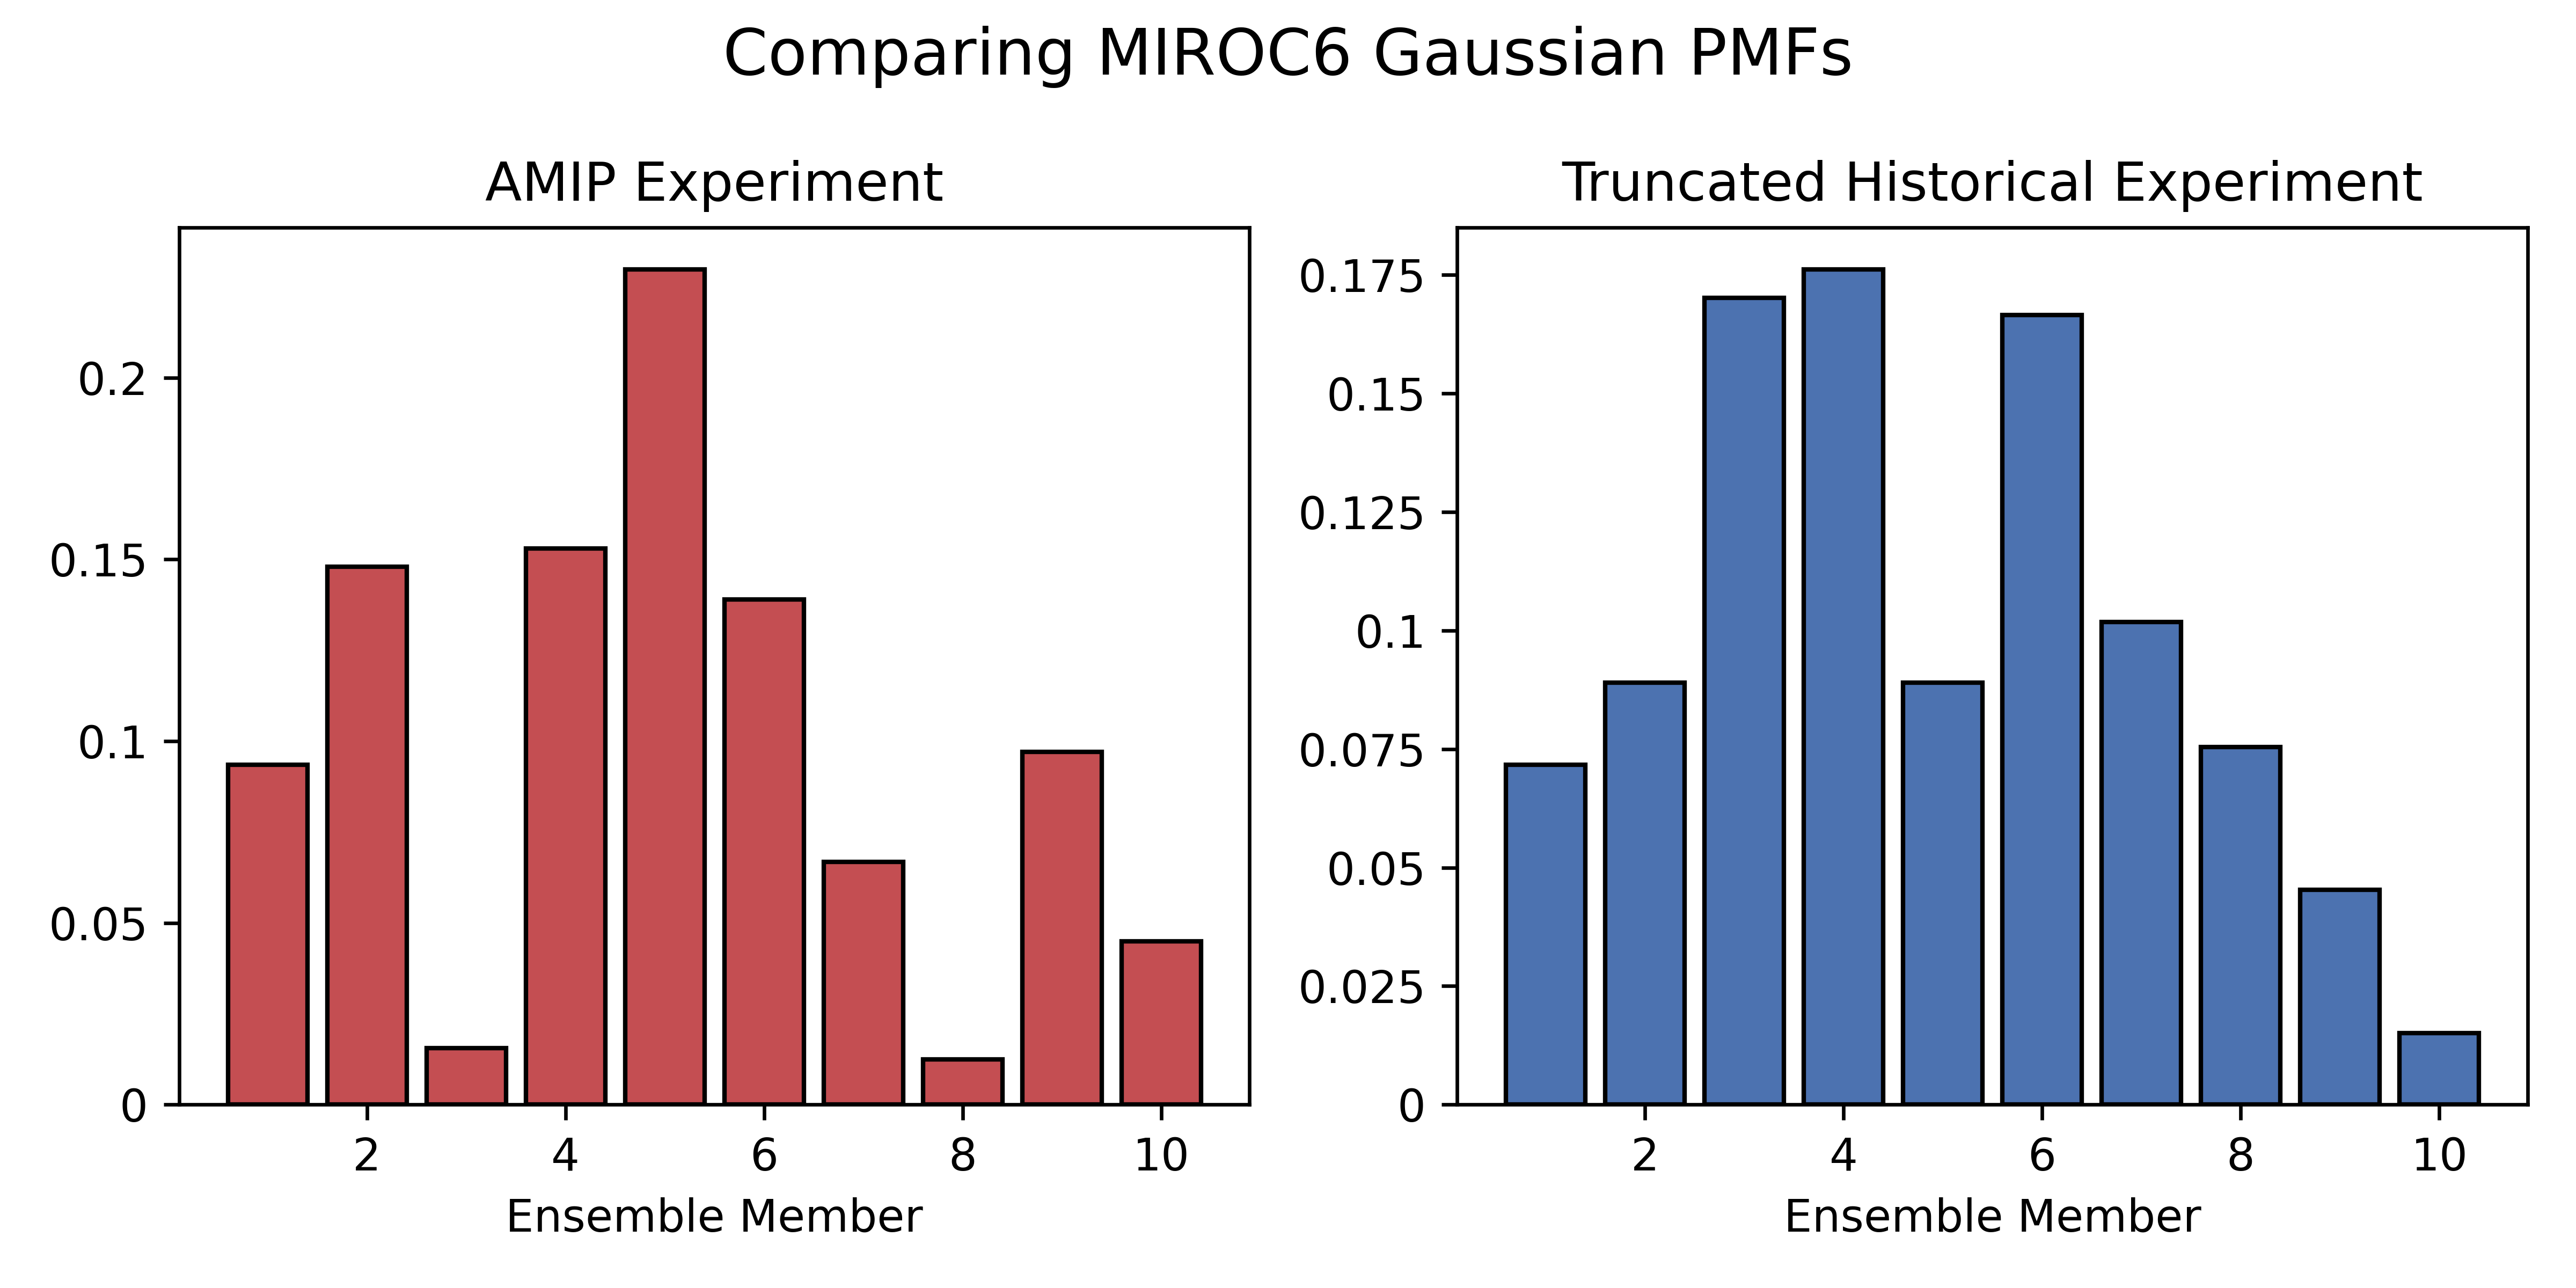

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (8,4), dpi=300)

ax[0].bar(x=np.linspace(1, len(amip_gaussian), len(amip_gaussian)),
        height=amip_gaussian_pmf, color='r', edgecolor='black', label='AMIP')

ax[1].bar(x=np.linspace(1, len(amip_gaussian), len(amip_gaussian)),
        height=historical_gaussian_pmf, color='b', edgecolor='black', label='historical')


ax[0].set_xlabel('Ensemble Member', fontsize='medium')
ax[0].title.set_text('AMIP Experiment')

ax[1].set_xlabel('Ensemble Member', fontsize='medium')
ax[1].title.set_text('Truncated Historical Experiment')

plt.suptitle('Comparing MIROC6 Gaussian PMFs', fontsize='x-large')

plt.tight_layout()

plt.savefig('images/gaussian_pmfs.eps', format='eps', bbox_inches='tight', dpi=300)

## KL Divergence

As the probability arrays have different lengths, we randomly select the 'matching' number of elements from the historical probabilities array, calculate the KL divergence, then repeat many times in order to calculate the average KL score.

In [23]:
def uneven_arrays(p,q): 
    #Match the array size
    if len(p) > len(q):
        p = np.random.choice(p, len(q))
    elif len(q) > len(p):
        q = np.random.choice(q, len(p))
    
    #Return the outputs
    return p, q

In [24]:
def uneven_KL(p, q, repeats):
    #Setup an empty array
    KL_scores = np.zeros(repeats)
    
    #Now repeat the KL calulation of the adjusted arrays
    for i in range(repeats):
        
        #Match the array size
        pMatched = uneven_arrays(p,q)[0]
        qMatched = uneven_arrays(p,q)[1]
    
        #Calculate KL divergence of matched arrays, in base 2 since it is nicer to work with
        KL_scores[i] = entropy(pMatched, qMatched, base=2)
    
    #Remove any unusually large values from the score
    KL_scores = KL_scores[KL_scores < 1e2]
    
    #Return the average KL divergence amongst these
    return np.mean(KL_scores)

<b>Note</b>: KL(p||q) asks how different an estimate distribution q is from the reference distribution p. As AMIP is our reference, we take p to this, and q to be the historical output.

In [57]:
KL_score = uneven_KL(p=amip_gaussian, q=historical_gaussian,repeats=10000)

In [58]:
print('The MIROC model achieved a KL score of:', np.round(KL_score,3))

The MIROC model achieved a KL score of: 0.923


### Alternative using closed form:

In [19]:
def KL_closed_form(mean_1, cov_1, mean_2, cov_2):
    mean_1 = np.reshape(mean_1, (3, 1))
    mean_2 = np.reshape(mean_2, (3, 1))

    first_part = np.log(
        np.linalg.det(cov_2) / np.linalg.det(cov_1)) + np.trace(
            np.dot((np.linalg.inv(cov_2)), cov_1))

    second_part = np.dot(
        np.dot((np.transpose(mean_2 - mean_1)), np.linalg.inv(cov_2)),
        (mean_2 - mean_1)) - len(mean_1)

    KL = 0.5 * (first_part + second_part)
    return KL[0,0]

In [20]:
KL_closed_form(amip_mean, amip_cov, historical_mean, historical_cov)

9.031345645979972

## JS Distance

In [59]:
def uneven_JS(p,q,repeats):
    #Setup an empty array
    JS_scores = np.zeros(repeats)
    
    #Now repeat the JS calulation of the adjusted arrays
    for i in range(repeats):
        
        #Match the array size
        pMatched = uneven_arrays(p,q)[0]
        qMatched = uneven_arrays(p,q)[1]
    
        #Calculate JS of matched arrays
        JS_scores[i] = jensenshannon(pMatched, qMatched)
    
    #Remove any unusually large values from the score
    JS_scores = JS_scores[JS_scores < 1e2]
    
    #Return the average KL divergence amongst these
    return np.mean(JS_scores)

In [60]:
JS_score = uneven_JS(p=amip_gaussian,
                     q=historical_gaussian,
                     repeats=10000)

In [61]:
print('The MIROC model achieved a JS score of:', np.round(JS_score,3))

The MIROC model achieved a JS score of: 0.349


## Wasserstein

To calculate the Wasserstein distance, we ignore the fitted Gaussian and perform the following steps:
<br> (1): Set the 3D points in each experiment to have a uniformly distributed mass
<br> (2): Calculate the cost matrix associated to the position of the 3D points in the two experiments
<br> (3): Use the weights and cost matrix to calculate the (approximate) Wasserstein distance/optimal transport cost.

In [5]:
amip_weights = np.ones((len(amip_outputs[:,0]), )) / len(amip_outputs[:,0])

historical_weights = np.ones((len(historical_outputs[:,0]), )) / len(historical_outputs[:,0])

### p=1

The GISS model achieved a Wasserstein-1 score of: 0.234
Wall time: 243 ms


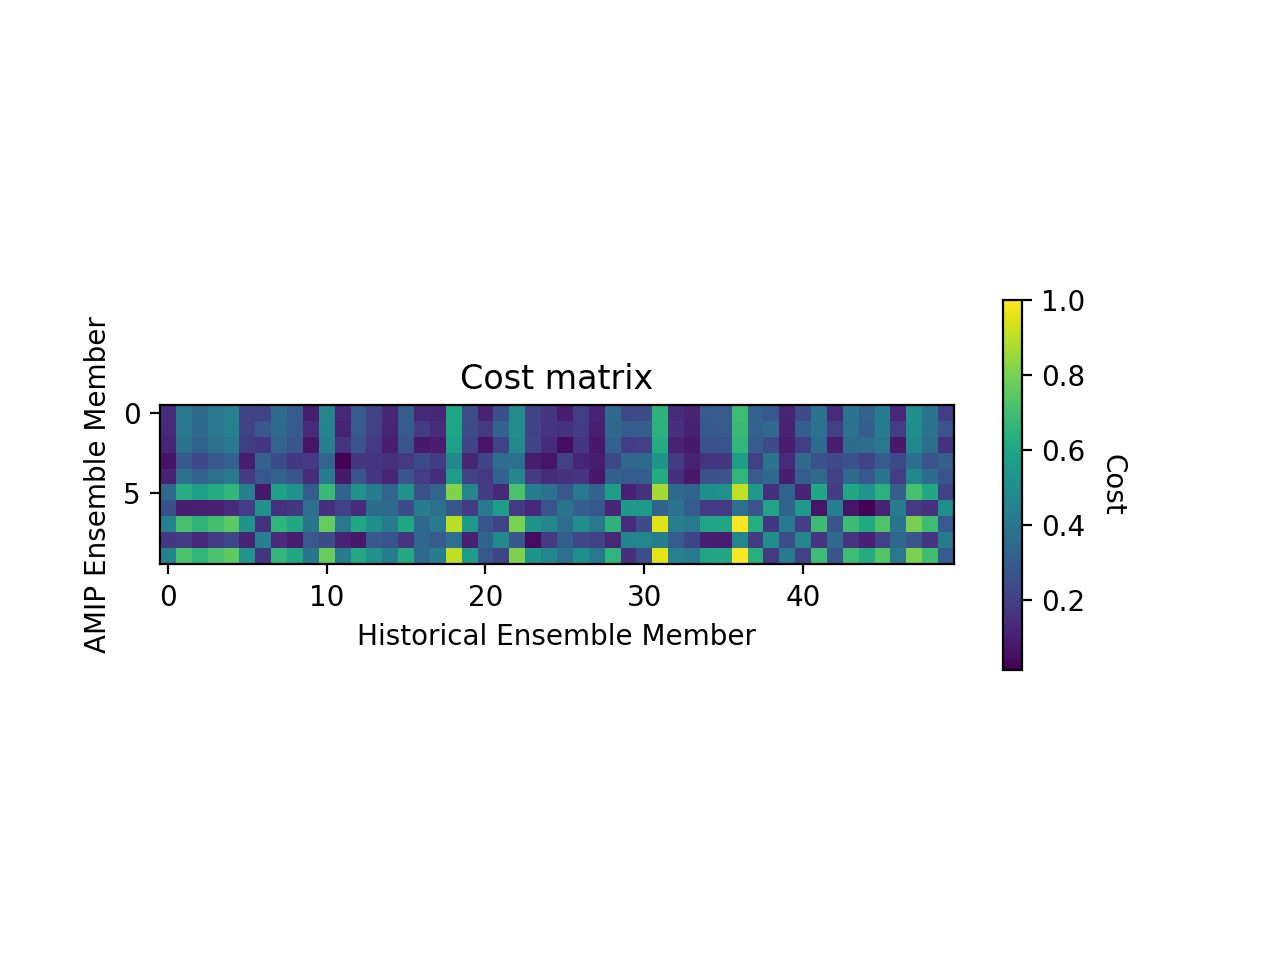

In [10]:
%%time

#Cheap fix to stop kernel dying:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#Generate the cost matrix with p=1
cost_matrix = ot.dist(amip_outputs, historical_outputs, metric='minkowski', p=1)

#Divide by the maximum value
cost_matrix /= cost_matrix.max()

#Plot the cost matrix:
plt.imshow(cost_matrix, interpolation ='nearest')

#Add a colorbar below
cbar = plt.colorbar(shrink=0.5)
cbar.set_label('Cost', rotation=270,labelpad=15)

plt.xlabel('Historical Ensemble Member')
plt.ylabel('AMIP Ensemble Member')
plt.title('Cost matrix')

plt.savefig('images/TasPrPsl_cost_matrix_p=1', bbox_inches='tight', dpi=300)

#Now compute Wasserstein distance, which takes the weights and the cost matrix
#NOTE: WE MUST TAKE THE pTH ROOT IN ORDER TO GET THE REAL WASSERSTEIN DISTANCE
wasserstein1_score = ot.emd2(amip_weights, historical_weights,
                            cost_matrix)**(1/1)
print('The GISS model achieved a Wasserstein-1 score of:', np.round(wasserstein1_score,3))

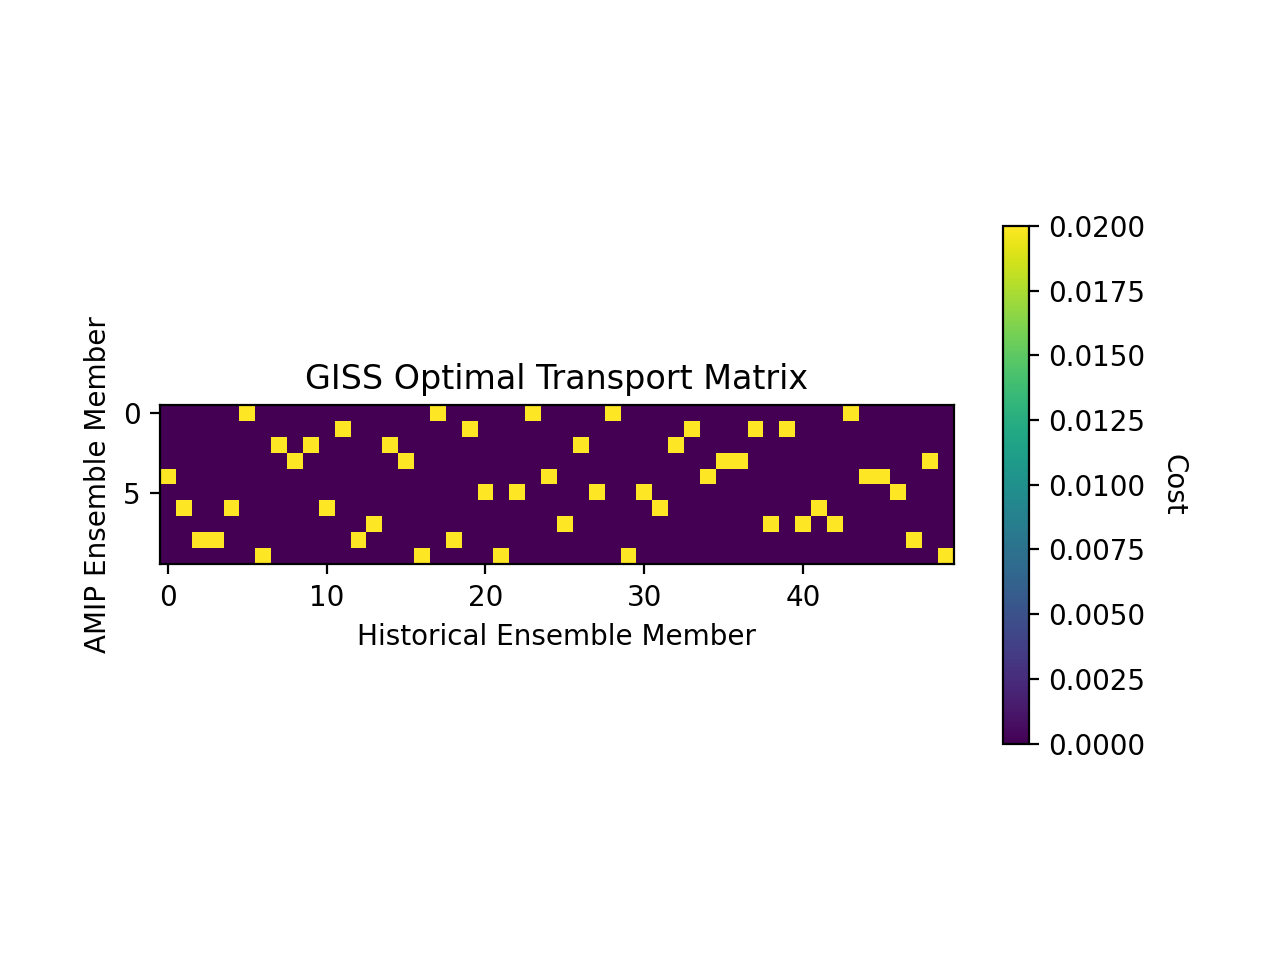

In [21]:
#Compute the optimal transport matrix:
optimal_transport = ot.emd(amip_weights, historical_weights,
                            cost_matrix)

plt.imshow(optimal_transport, interpolation='nearest')

#Add a colorbar below
cbar = plt.colorbar(shrink=0.7)
cbar.set_label('Cost', rotation=270,labelpad=15)

plt.xlabel('Historical Ensemble Member')
plt.ylabel('AMIP Ensemble Member')
plt.title('GISS Optimal Transport Matrix')

plt.savefig('images/TasPrPsl_optimal_transport_matrix_p=1', bbox_inches='tight', dpi=300)

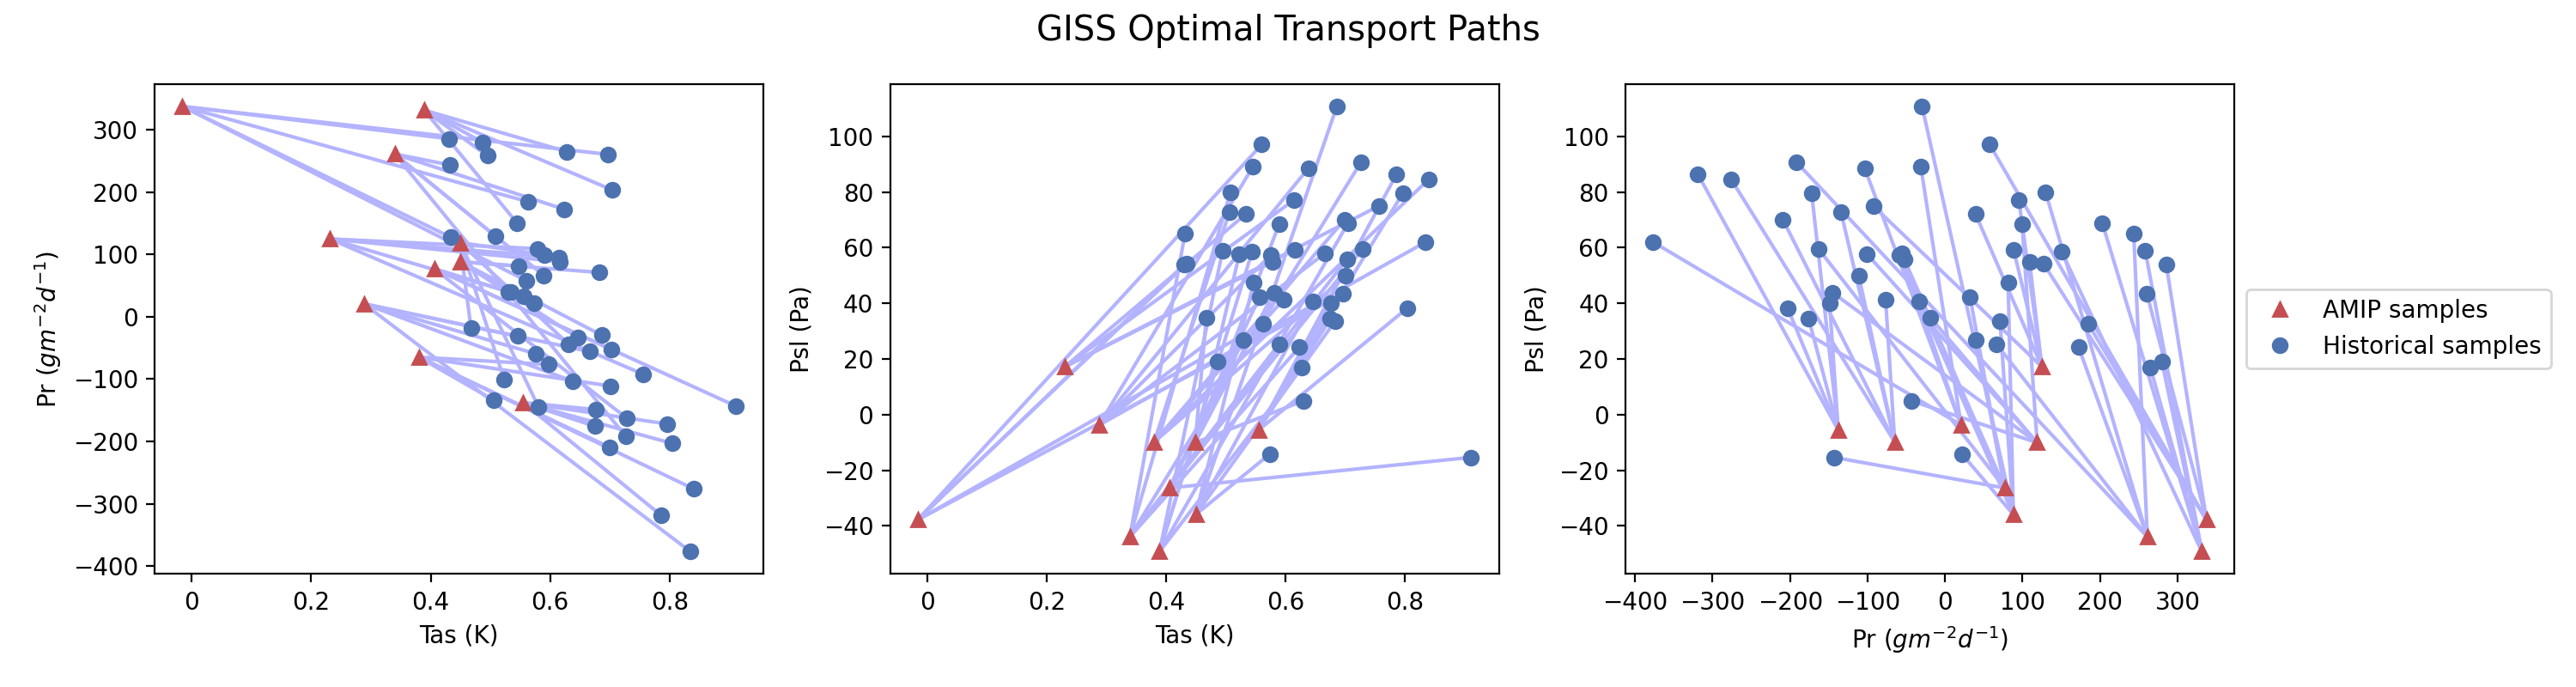

In [22]:
plt.figure(1, figsize=(15, 4))

plt.suptitle("GISS Optimal Transport Paths", fontsize="x-large")

#Tas vs Pr
plt.subplot(1, 3, 1)

ot.plot.plot2D_samples_mat(amip_outputs[:,[0,1]], historical_outputs[:,[0,1]], optimal_transport, c=[.7, .7, 1])
plt.plot(amip_outputs[:, 0], amip_outputs[:, 1], 'r^', label='AMIP samples')
plt.plot(historical_outputs[:, 0], historical_outputs[:, 1], 'ob', label='Historical samples')

plt.xlabel('Tas (K)')
plt.ylabel('Pr ($g m^{-2} d^{-1}$)')


#Tas vs Psl
plt.subplot(1, 3, 2)

ot.plot.plot2D_samples_mat(amip_outputs[:,[0,2]], historical_outputs[:,[0,2]], optimal_transport, c=[.7, .7, 1])
plt.plot(amip_outputs[:, 0], amip_outputs[:, 2], 'r^', label='AMIP samples')
plt.plot(historical_outputs[:, 0], historical_outputs[:, 2], 'ob', label='Historical samples')

plt.xlabel('Tas (K)')
plt.ylabel('Psl (Pa)')


#Pr vs Psl
plt.subplot(1, 3, 3)

ot.plot.plot2D_samples_mat(amip_outputs[:,[1,2]], historical_outputs[:,[1,2]], optimal_transport, c=[.7, .7, 1])
plt.plot(amip_outputs[:, 1], amip_outputs[:, 2], 'r^', label='AMIP samples')
plt.plot(historical_outputs[:, 1], historical_outputs[:, 2], 'ob', label='Historical samples')

plt.xlabel('Pr ($g m^{-2} d^{-1}$)')
plt.ylabel('Psl (Pa)')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig('images/TasPrPsl_optimal_transport_paths_p=1', bbox_inches='tight', dpi=300)

### p=2

The GISS model achieved a Wasserstein-2 score of: 0.442
Wall time: 250 ms


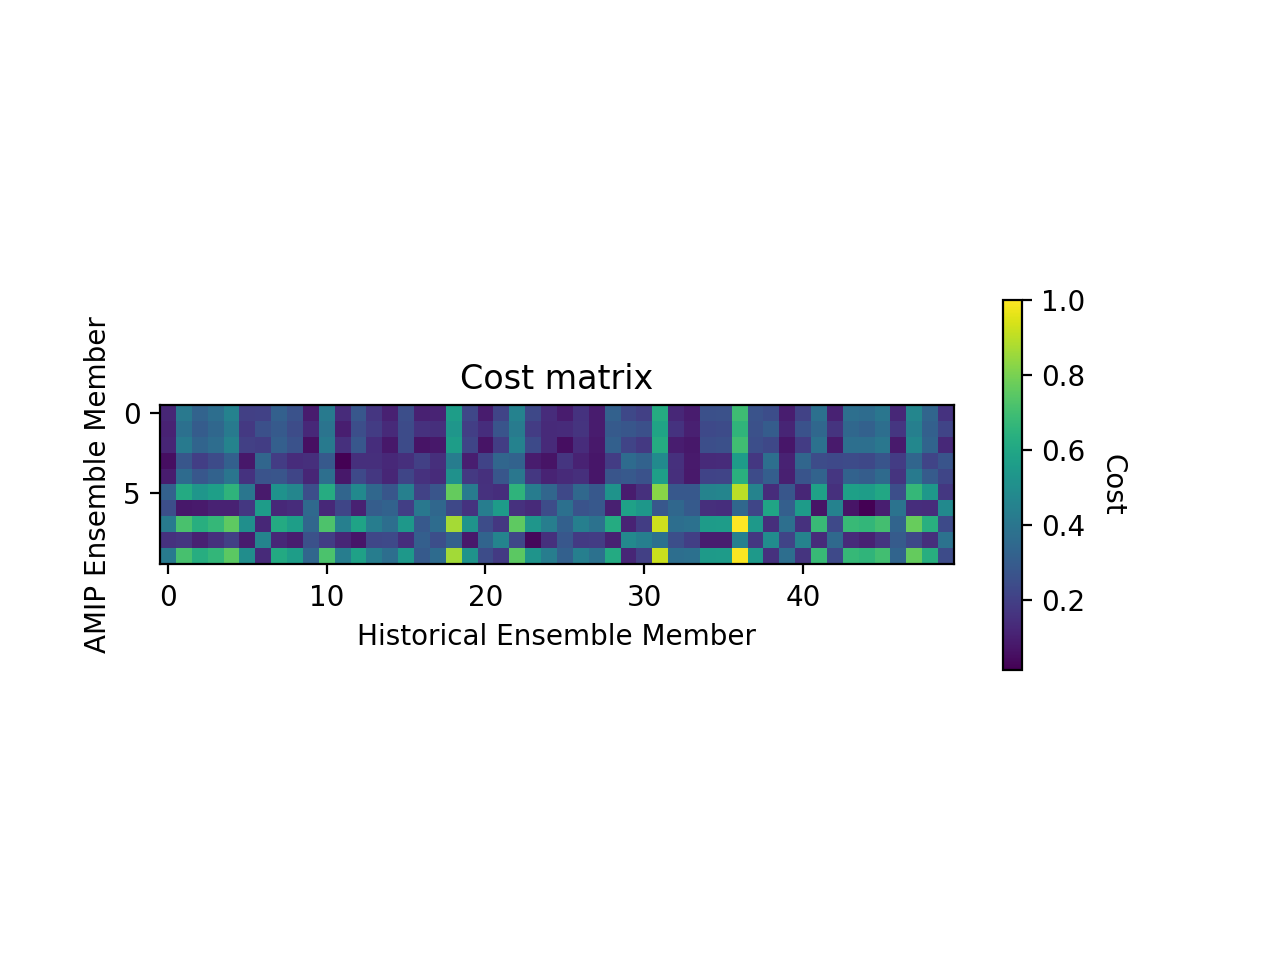

In [11]:
%%time

#Cheap fix to stop kernel dying:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#Generate the cost matrix with p=2
cost_matrix = ot.dist(amip_outputs, historical_outputs, metric='minkowski', p=2)

#Divide by the maximum value
cost_matrix /= cost_matrix.max()

#Plot the cost matrix:
plt.imshow(cost_matrix, interpolation ='nearest')

#Add a colorbar below
cbar = plt.colorbar(shrink=0.5)
cbar.set_label('Cost', rotation=270,labelpad=15)

plt.xlabel('Historical Ensemble Member')
plt.ylabel('AMIP Ensemble Member')
plt.title('Cost matrix')

plt.savefig('images/TasPrPsl_cost_matrix_p=2', bbox_inches='tight', dpi=300)

#Now compute Wasserstein distance, which takes the weights and the cost matrix
#NOTE: WE MUST TAKE THE pTH ROOT IN ORDER TO GET THE REAL WASSERSTEIN DISTANCE
wasserstein2_score = ot.emd2(amip_weights, historical_weights,
                            cost_matrix)**(1/2)
print('The GISS model achieved a Wasserstein-2 score of:', np.round(wasserstein2_score,3))

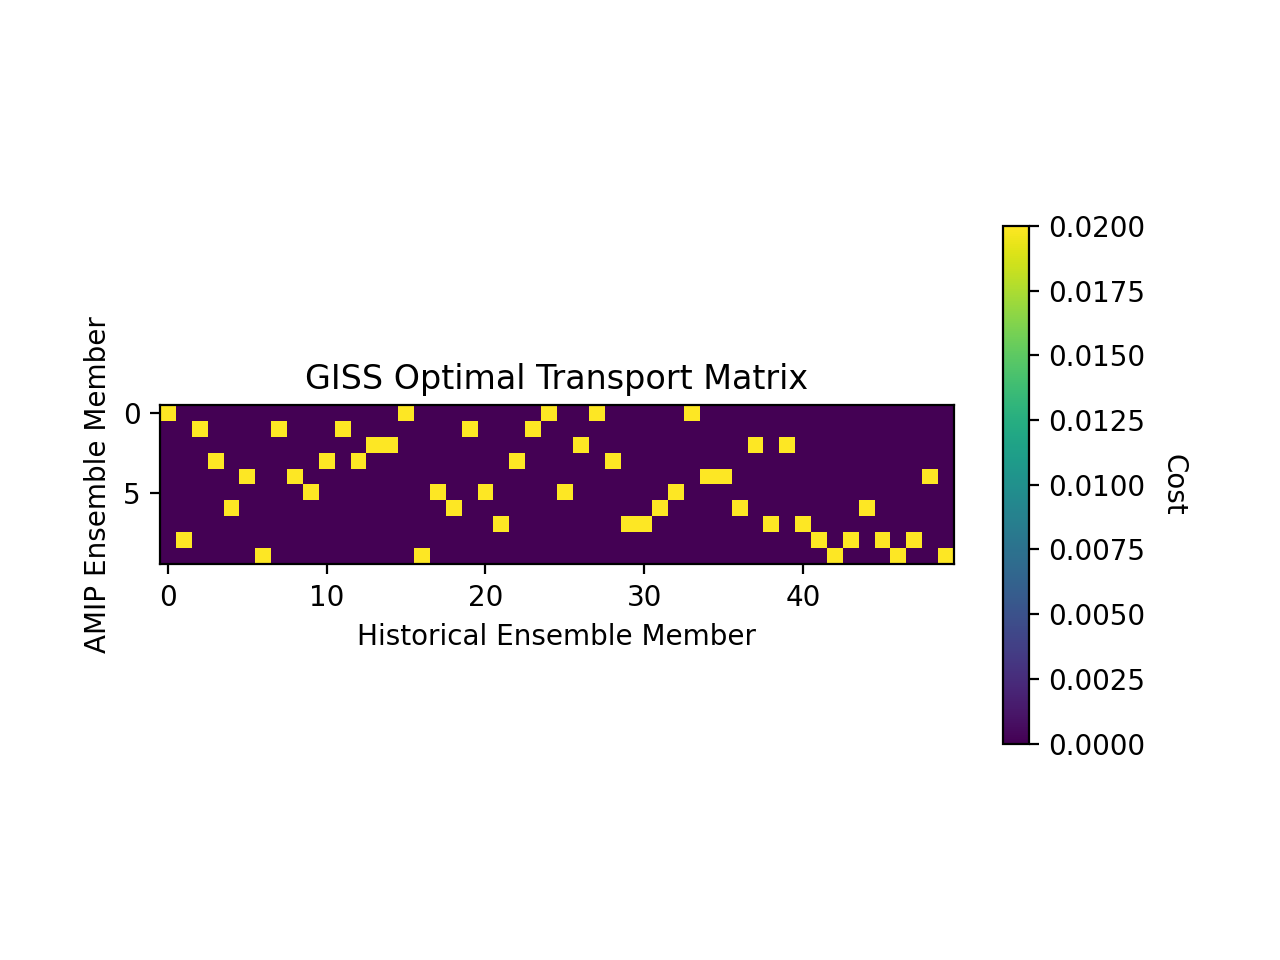

In [24]:
#Compute the optimal transport matrix:
optimal_transport = ot.emd(amip_weights, historical_weights,
                            cost_matrix)

plt.imshow(optimal_transport, interpolation='nearest')

#Add a colorbar below
cbar = plt.colorbar(shrink=0.7)
cbar.set_label('Cost', rotation=270,labelpad=15)

plt.xlabel('Historical Ensemble Member')
plt.ylabel('AMIP Ensemble Member')
plt.title('GISS Optimal Transport Matrix')

plt.savefig('images/TasPrPsl_optimal_transport_matrix_p=2', bbox_inches='tight', dpi=300)

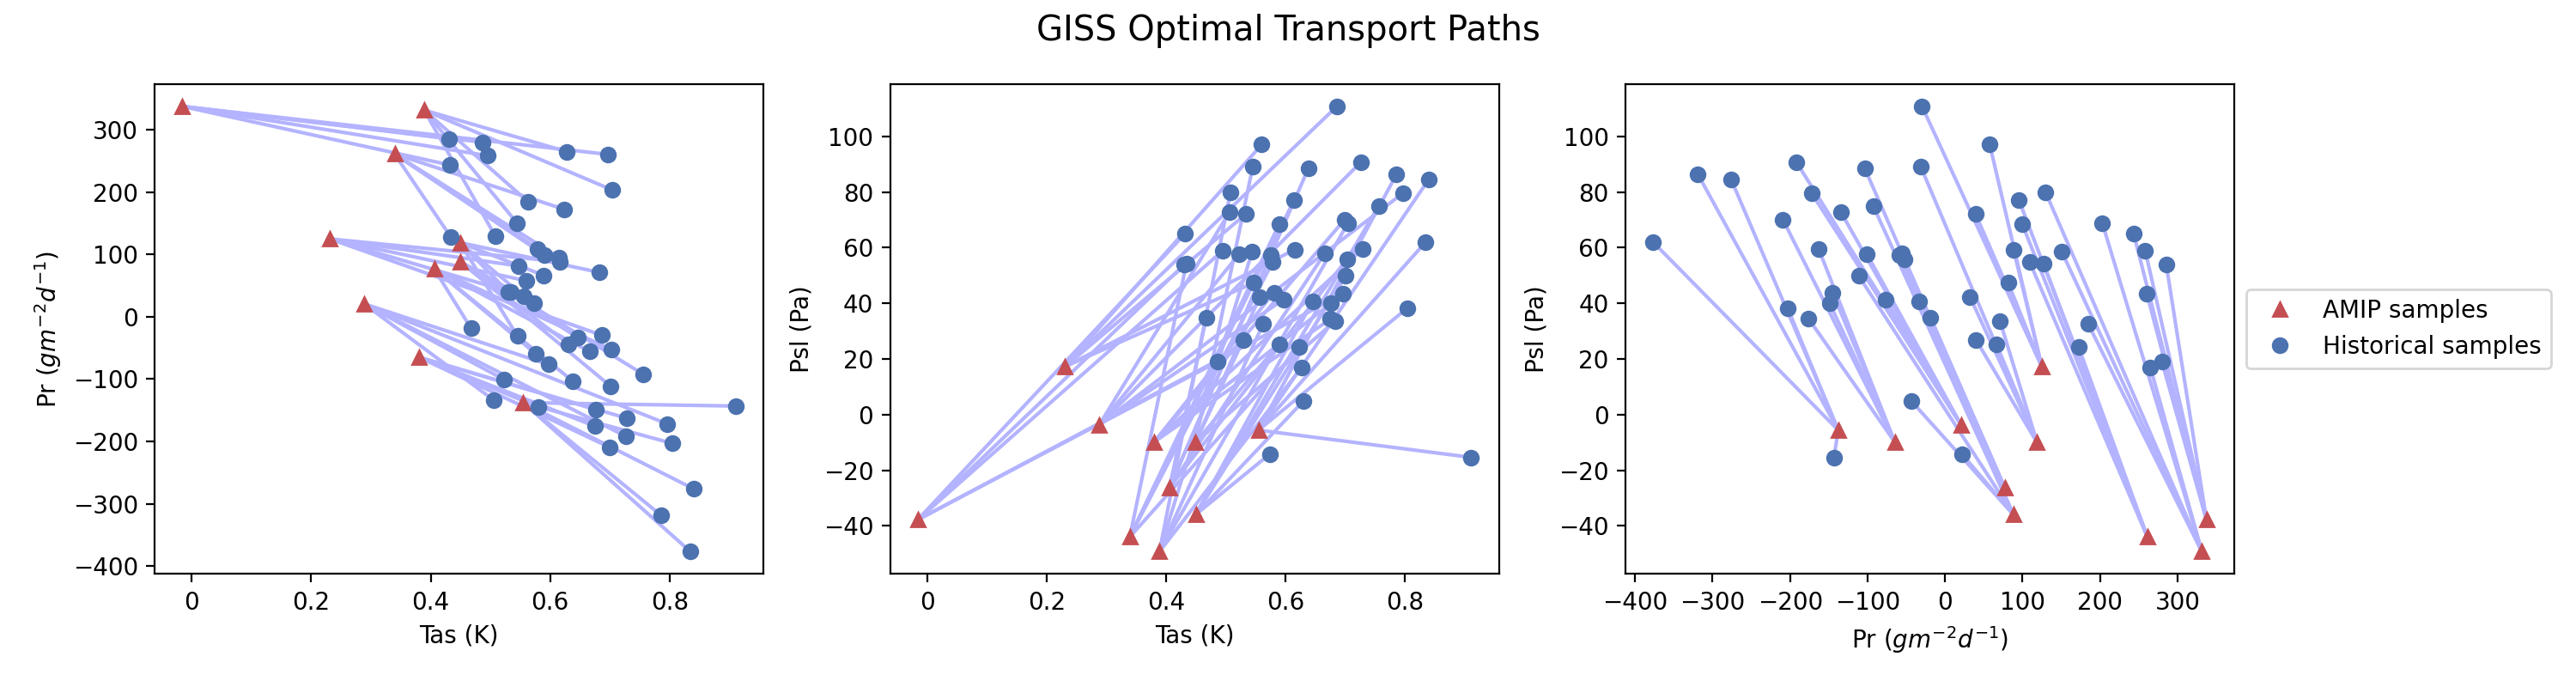

In [25]:
plt.figure(1, figsize=(15, 4))

plt.suptitle("GISS Optimal Transport Paths", fontsize="x-large")

#Tas vs Pr
plt.subplot(1, 3, 1)

ot.plot.plot2D_samples_mat(amip_outputs[:,[0,1]], historical_outputs[:,[0,1]], optimal_transport, c=[.7, .7, 1])
plt.plot(amip_outputs[:, 0], amip_outputs[:, 1], 'r^', label='AMIP samples')
plt.plot(historical_outputs[:, 0], historical_outputs[:, 1], 'ob', label='Historical samples')

plt.xlabel('Tas (K)')
plt.ylabel('Pr ($g m^{-2} d^{-1}$)')


#Tas vs Psl
plt.subplot(1, 3, 2)

ot.plot.plot2D_samples_mat(amip_outputs[:,[0,2]], historical_outputs[:,[0,2]], optimal_transport, c=[.7, .7, 1])
plt.plot(amip_outputs[:, 0], amip_outputs[:, 2], 'r^', label='AMIP samples')
plt.plot(historical_outputs[:, 0], historical_outputs[:, 2], 'ob', label='Historical samples')

plt.xlabel('Tas (K)')
plt.ylabel('Psl (Pa)')


#Pr vs Psl
plt.subplot(1, 3, 3)

ot.plot.plot2D_samples_mat(amip_outputs[:,[1,2]], historical_outputs[:,[1,2]], optimal_transport, c=[.7, .7, 1])
plt.plot(amip_outputs[:, 1], amip_outputs[:, 2], 'r^', label='AMIP samples')
plt.plot(historical_outputs[:, 1], historical_outputs[:, 2], 'ob', label='Historical samples')

plt.xlabel('Pr ($g m^{-2} d^{-1}$)')
plt.ylabel('Psl (Pa)')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig('images/TasPrPsl_optimal_transport_paths_p=2', bbox_inches='tight', dpi=300)

### p=3

The GISS model achieved a Wasserstein-3 score of: 0.565
Wall time: 255 ms


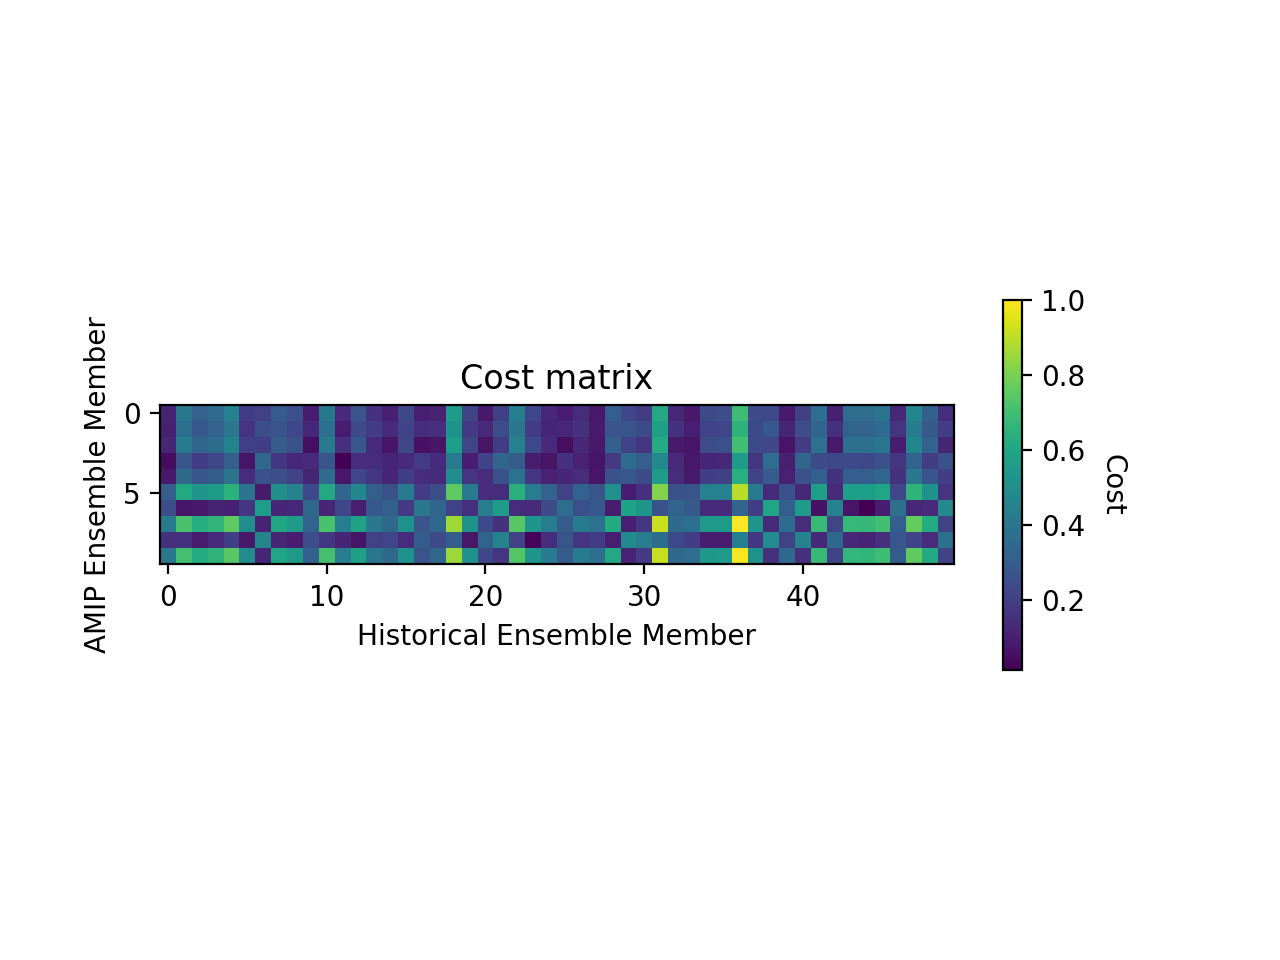

In [12]:
%%time

#Cheap fix to stop kernel dying:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#Generate the cost matrix with p=3
cost_matrix = ot.dist(amip_outputs, historical_outputs, metric='minkowski', p=3)

#Divide by the maximum value
cost_matrix /= cost_matrix.max()

#Plot the cost matrix:
plt.imshow(cost_matrix, interpolation ='nearest')

#Add a colorbar below
cbar = plt.colorbar(shrink=0.5)
cbar.set_label('Cost', rotation=270,labelpad=15)

plt.xlabel('Historical Ensemble Member')
plt.ylabel('AMIP Ensemble Member')
plt.title('Cost matrix')

plt.savefig('images/TasPrPsl_cost_matrix_p=3', bbox_inches='tight', dpi=300)

#Now compute Wasserstein distance, which takes the weights and the cost matrix
#NOTE: WE MUST TAKE THE pTH ROOT IN ORDER TO GET THE REAL WASSERSTEIN DISTANCE
wasserstein3_score = ot.emd2(amip_weights, historical_weights,
                            cost_matrix)**(1/3)
print('The GISS model achieved a Wasserstein-3 score of:', np.round(wasserstein3_score,3))

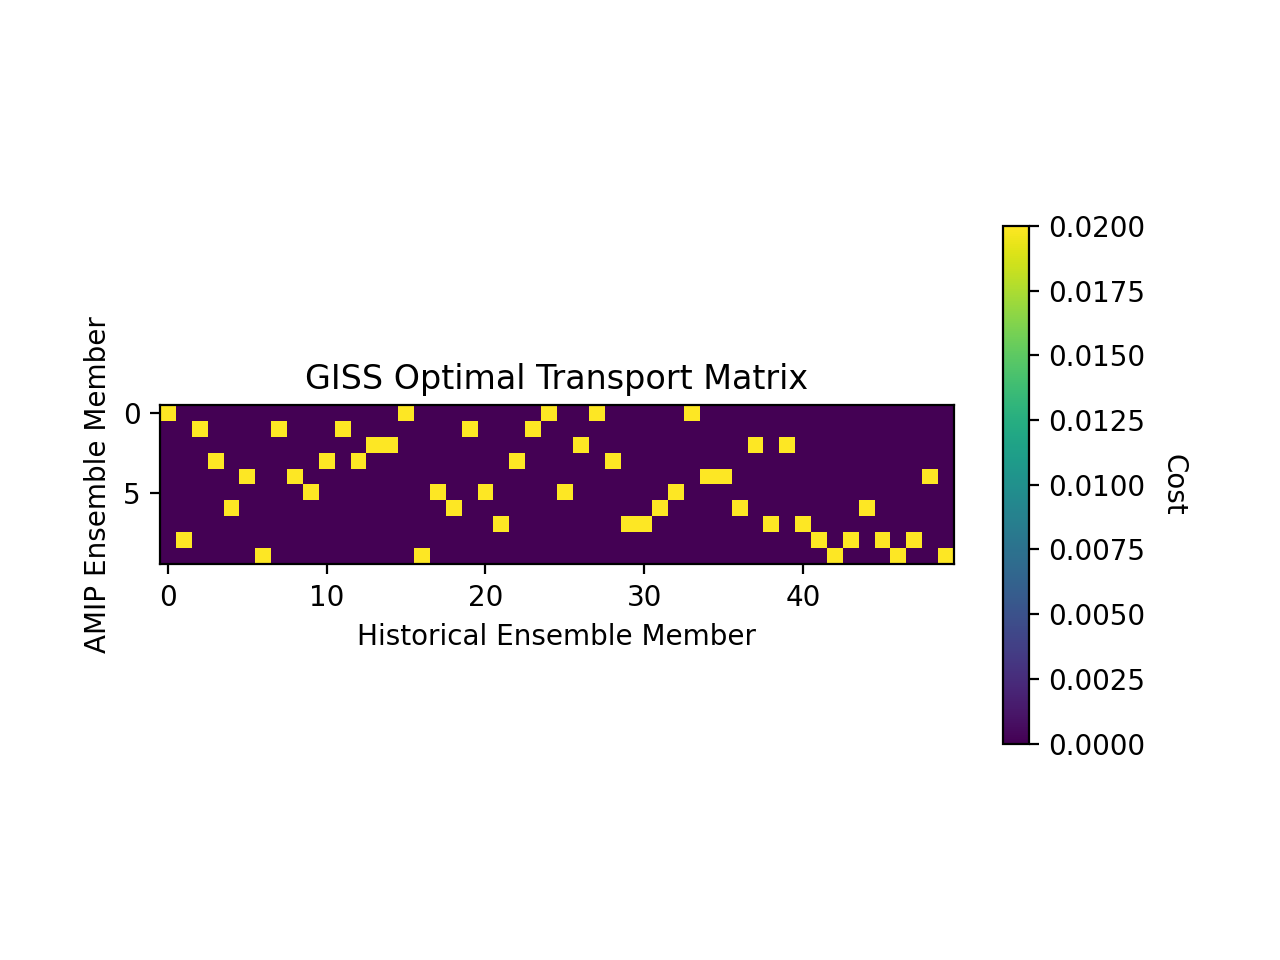

In [27]:
#Compute the optimal transport matrix:
optimal_transport = ot.emd(amip_weights, historical_weights,
                            cost_matrix)

plt.imshow(optimal_transport, interpolation='nearest')

#Add a colorbar below
cbar = plt.colorbar(shrink=0.7)
cbar.set_label('Cost', rotation=270,labelpad=15)

plt.xlabel('Historical Ensemble Member')
plt.ylabel('AMIP Ensemble Member')
plt.title('GISS Optimal Transport Matrix')

plt.savefig('images/TasPrPsl_optimal_transport_matrix_p=3', bbox_inches='tight', dpi=300)

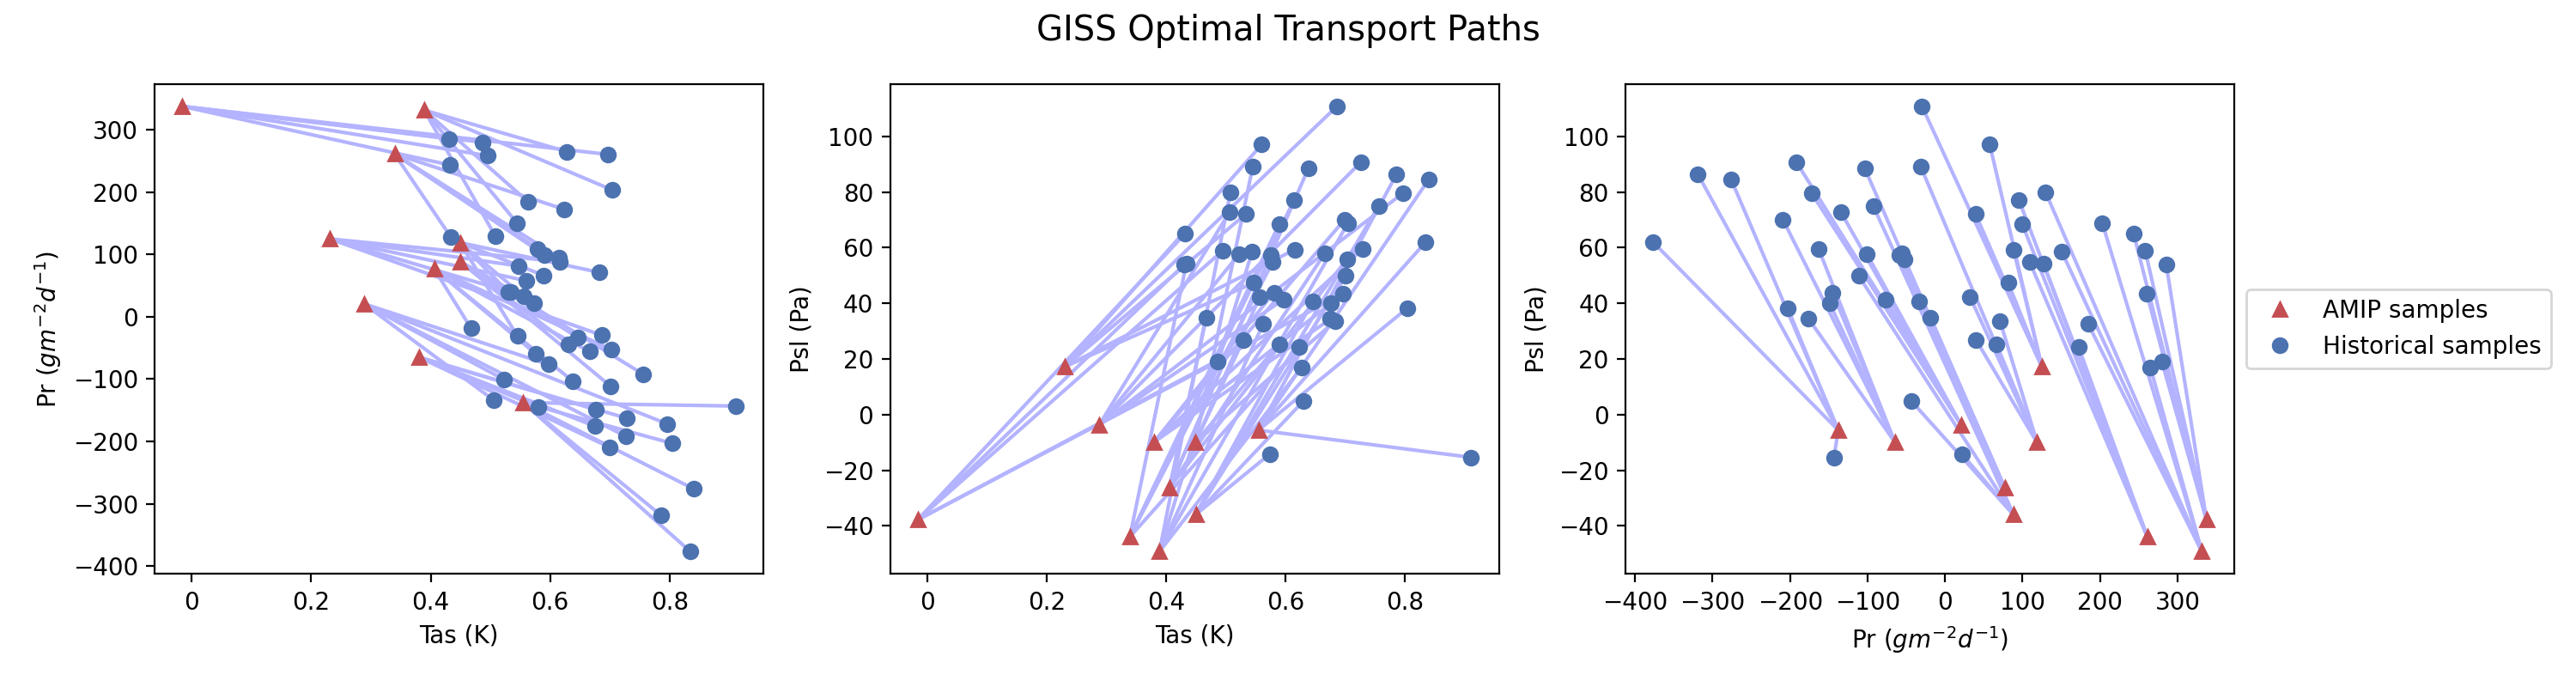

In [28]:
plt.figure(1, figsize=(15, 4))

plt.suptitle("GISS Optimal Transport Paths", fontsize="x-large")

#Tas vs Pr
plt.subplot(1, 3, 1)

ot.plot.plot2D_samples_mat(amip_outputs[:,[0,1]], historical_outputs[:,[0,1]], optimal_transport, c=[.7, .7, 1])
plt.plot(amip_outputs[:, 0], amip_outputs[:, 1], 'r^', label='AMIP samples')
plt.plot(historical_outputs[:, 0], historical_outputs[:, 1], 'ob', label='Historical samples')

plt.xlabel('Tas (K)')
plt.ylabel('Pr ($g m^{-2} d^{-1}$)')


#Tas vs Psl
plt.subplot(1, 3, 2)

ot.plot.plot2D_samples_mat(amip_outputs[:,[0,2]], historical_outputs[:,[0,2]], optimal_transport, c=[.7, .7, 1])
plt.plot(amip_outputs[:, 0], amip_outputs[:, 2], 'r^', label='AMIP samples')
plt.plot(historical_outputs[:, 0], historical_outputs[:, 2], 'ob', label='Historical samples')

plt.xlabel('Tas (K)')
plt.ylabel('Psl (Pa)')


#Pr vs Psl
plt.subplot(1, 3, 3)

ot.plot.plot2D_samples_mat(amip_outputs[:,[1,2]], historical_outputs[:,[1,2]], optimal_transport, c=[.7, .7, 1])
plt.plot(amip_outputs[:, 1], amip_outputs[:, 2], 'r^', label='AMIP samples')
plt.plot(historical_outputs[:, 1], historical_outputs[:, 2], 'ob', label='Historical samples')

plt.xlabel('Pr ($g m^{-2} d^{-1}$)')
plt.ylabel('Psl (Pa)')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig('images/TasPrPsl_optimal_transport_paths_p=3', bbox_inches='tight', dpi=300)

### Summarise

In [32]:
wasserstein_scores = [wasserstein1_score, wasserstein2_score, wasserstein3_score]
np.round(wasserstein_scores,3)

array([0.234, 0.442, 0.565])

### Old

In [63]:
#Generate the cost matrix
cost_matrix = ot.dist(amip_outputs, historical_outputs)

#Divide by the maximum value
cost_matrix /= cost_matrix.max()

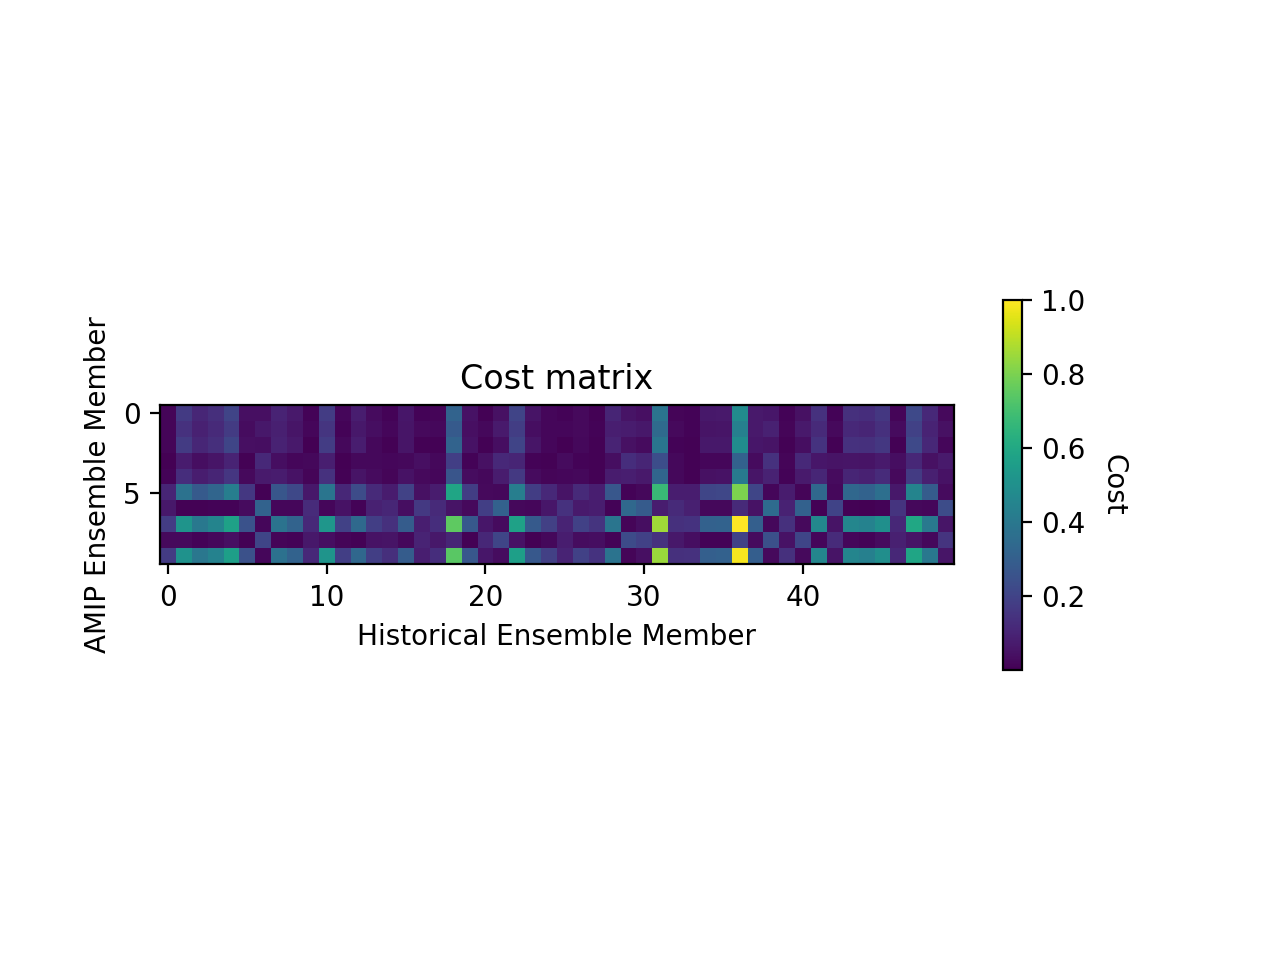

In [74]:
#Cheap fix to stop kernel dying:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#Plot the cost matrix:
plt.imshow(cost_matrix, interpolation ='nearest')

#Add a colorbar below
cbar = plt.colorbar(shrink=0.5)
cbar.set_label('Cost', rotation=270,labelpad=15)
plt.xlabel('Historical Ensemble Member')
plt.ylabel('AMIP Ensemble Member')
plt.title('Cost matrix')

plt.savefig('images/TasPrPsl_cost_matrix', bbox_inches='tight', dpi=300)

In [75]:
#Now compute Wasserstein distance, which takes the weights and the cost matrix
wasserstein_score = ot.emd2(amip_weights, historical_weights,
                            cost_matrix)
print('The MIROC model achieved a Wasserstein score of:', np.round(wasserstein_score,3))

The MIROC model achieved a Wasserstein score of: 0.043


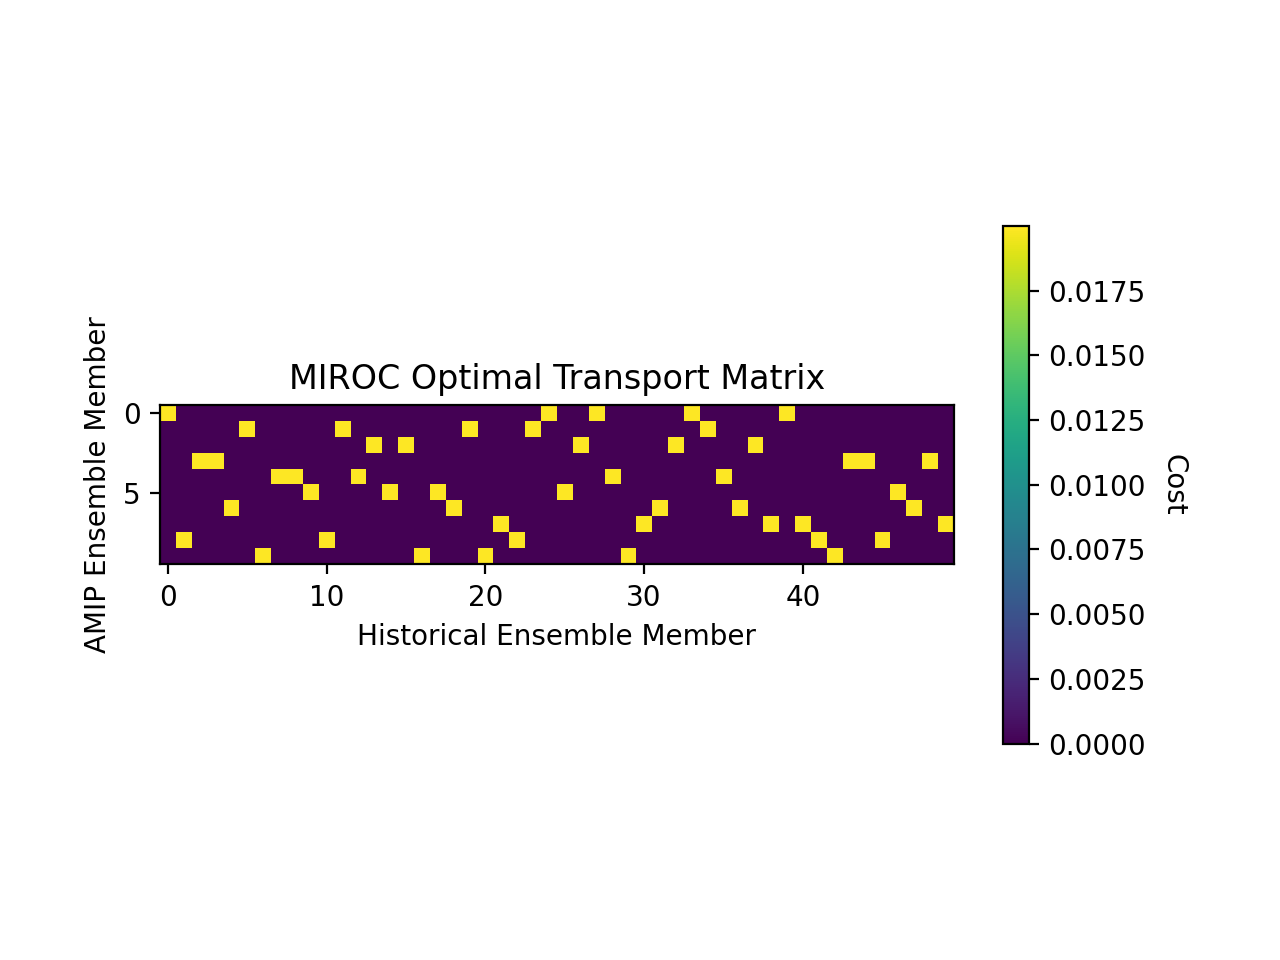

In [76]:
#Compute the optimal transport matrix:
optimal_transport = ot.emd(amip_weights, historical_weights,
                            cost_matrix)

plt.imshow(optimal_transport, interpolation='nearest')

#Add a colorbar below
cbar = plt.colorbar(shrink=0.7)
cbar.set_label('Cost', rotation=270,labelpad=15)

plt.xlabel('Historical Ensemble Member')
plt.ylabel('AMIP Ensemble Member')
plt.title('MIROC Optimal Transport Matrix')

plt.savefig('images/TasPrPsl_optimal_transport_matrix', bbox_inches='tight', dpi=300)

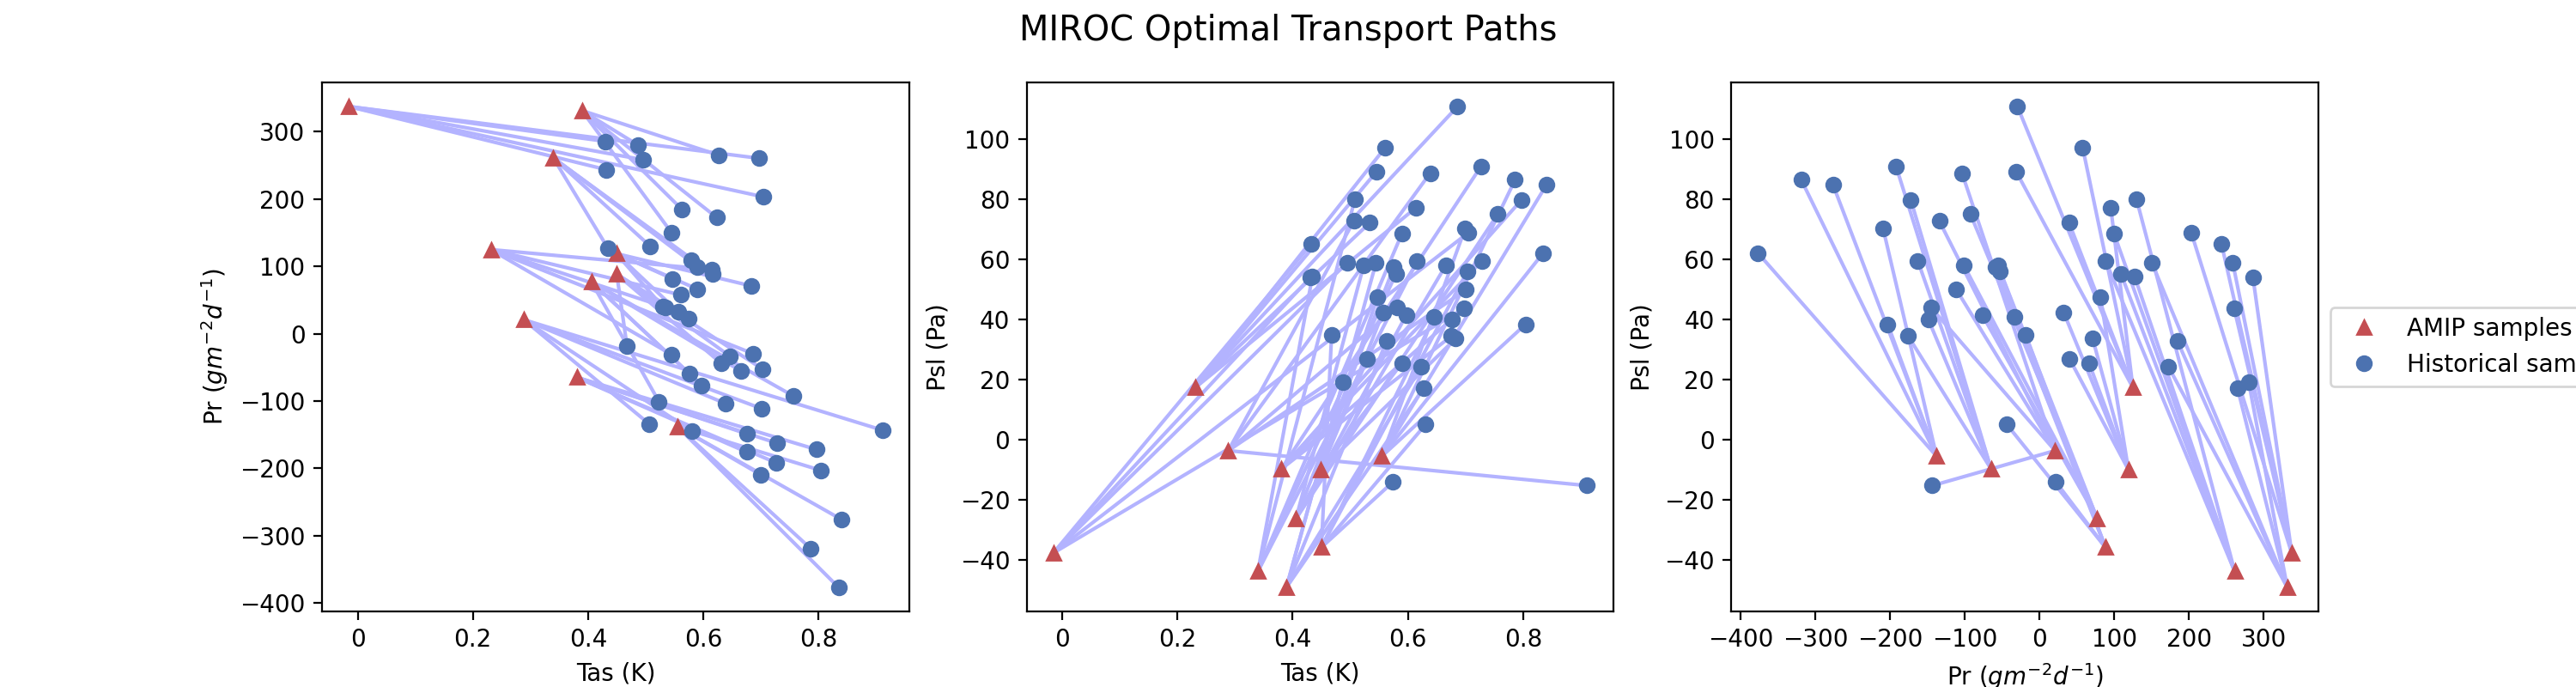

In [77]:
plt.figure(1, figsize=(15, 4))

plt.suptitle("MIROC Optimal Transport Paths", fontsize="x-large")

#Tas vs Pr
plt.subplot(1, 3, 1)

ot.plot.plot2D_samples_mat(amip_outputs[:,[0,1]], historical_outputs[:,[0,1]], optimal_transport, c=[.7, .7, 1])
plt.plot(amip_outputs[:, 0], amip_outputs[:, 1], 'r^', label='AMIP samples')
plt.plot(historical_outputs[:, 0], historical_outputs[:, 1], 'ob', label='Historical samples')

plt.xlabel('Tas (K)')
plt.ylabel('Pr ($g m^{-2} d^{-1}$)')


#Tas vs Psl
plt.subplot(1, 3, 2)

ot.plot.plot2D_samples_mat(amip_outputs[:,[0,2]], historical_outputs[:,[0,2]], optimal_transport, c=[.7, .7, 1])
plt.plot(amip_outputs[:, 0], amip_outputs[:, 2], 'r^', label='AMIP samples')
plt.plot(historical_outputs[:, 0], historical_outputs[:, 2], 'ob', label='Historical samples')

plt.xlabel('Tas (K)')
plt.ylabel('Psl (Pa)')


#Pr vs Psl
plt.subplot(1, 3, 3)

ot.plot.plot2D_samples_mat(amip_outputs[:,[1,2]], historical_outputs[:,[1,2]], optimal_transport, c=[.7, .7, 1])
plt.plot(amip_outputs[:, 1], amip_outputs[:, 2], 'r^', label='AMIP samples')
plt.plot(historical_outputs[:, 1], historical_outputs[:, 2], 'ob', label='Historical samples')

plt.xlabel('Pr ($g m^{-2} d^{-1}$)')
plt.ylabel('Psl (Pa)')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('images/TasPrPsl_optimal_transport_paths', bbox_inches='tight', dpi=300)

## Energy Distance

We use the Dcor package, which estimates the energy distance using Hoeffding's unbiased U statistics (see Dcor documentation for more info).
<br> However, the result returned is the <b>squared</b> distance, which is not a metric. So, we take the square root.

In [33]:
energy_score = np.sqrt(dcor.energy_distance(amip_outputs,historical_outputs))

In [34]:
print('The MIROC model achieved an energy score of:', np.round(energy_score,3))

The MIROC model achieved an energy score of: 9.201


My implementation, using the empirical estimators of expectation found by summing pairwise differences:

In [5]:
def calculate_energy_statistics(x, y):

    n = len(x)
    m = len(y)

    A = 0
    B = 0
    C = 0

    for i in range(n):
        for j in range(m):
            A += np.linalg.norm(x[i] - y[j])

    A = A / (n * m)

    for i in range(n):
        for j in range(n):
            B += np.linalg.norm(x[i] - x[j])

    B = B / (n * n)

    for i in range(m):
        for j in range(m):
            C += np.linalg.norm(y[i] - y[j])

    C = C / (m * m)

    energy_distance = np.sqrt(2 * A - B - C)

    test_statistic = (2 * A - B - C) / (2 * A)

    return {
        'Energy distance': np.round(energy_distance, 3),
        'Test statistic': np.round(test_statistic, 3)
    }

In [6]:
calculate_energy_statistics(amip_outputs, historical_outputs)

{'Energy distance': 9.201, 'Test statistic': 0.189}